# Análisis de los precios del mercado de la vivienda en España

El objetivo de este análisis es analizar la evolución del precio de los alquileres y de la venta de viviendas en España en conjunción con algunos datos socio-económicos.  
Para ello, se han obtenido 4 sets de datos:  

- Precios medios de los alquileres y viviendas en venta por provincia (Web Scraping de la Web de idealista)
- Evolución de la población por provincia (INE)
- Número de turistas por provincia (INE)
- Evolución del salario mediano por provincia (INE)  
- Viviendas construidas (Ministerio de Transportes)

La principal tarea va a ser ver como están relacionados los precios de venta y de alquiler entre si y con estos datos mencionados anteriormente

## 1. Hipótesis  

Se va a buscar analizar la validez de las siguientes hipótesis:  

- El precio de la vivienda y del alquiler están correlacionados. Es decir, si el precio de la vivienda sube, el del alquiler también.
- El precio de venta de la vivienda está influenciado por incremento o disminución del número de habitantes de la provincia.
- El precio del alquiler se verá influenciado por el número de turistas que reciba cada provincia.
- El salario mediano afectará de forma directamente proporcional tanto al precio de venta como al del alquiler.
- Una disminución del ritmo de construcción de viviendas (es decir, el número de viviendas no crece) hará que el precio suba.

## 2.Datos  

Los sets de datos que se van a emplear han sido obtenidos de distintas fuentes y procesados en el NoteBook "Idealista-tratamiento.ipynb". Se va a proceder a importarlos y cargarlos en datasets separados:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df_venta = pd.read_csv("../data/datasets_corregidos/csv_idealista_venta_corregido.csv", sep=";" ,header=0, index_col=0)
df_alquiler = pd.read_csv("../data/datasets_corregidos/csv_idealista_alquiler_corregido.csv", sep=";" ,header=0, index_col=0)
df_turismo = pd.read_csv("../data/datasets_corregidos/csv_turismo_corregido.csv", sep=";" ,header=0, index_col=0)
df_salarios = pd.read_csv("../data/datasets_corregidos/csv_salarios_corregido.csv", sep=";" ,header=0, index_col=0)
df_poblacion = pd.read_csv("../data/datasets_corregidos/csv_poblacion_corregido.csv", sep=";" ,header=0, index_col=0)
df_viviendas = pd.read_csv("../data/datasets_corregidos/csv_vivienda_corregido.csv", sep=";" ,header=0, index_col=0)

df_venta['Fecha'] = pd.to_datetime(df_venta['Fecha'])
df_alquiler['Fecha'] = pd.to_datetime(df_alquiler['Fecha'])
df_turismo['Fecha'] = pd.to_datetime(df_turismo['Fecha'])
df_salarios['Fecha'] = pd.to_datetime(df_salarios['Fecha'])
df_poblacion['Fecha'] = pd.to_datetime(df_poblacion['Fecha'])
df_viviendas['Fecha'] = pd.to_datetime(df_viviendas['Fecha'])

Mostramos las tres primeras filas de cada uno para observar como están organizados los datos:

In [3]:
df_venta.head(3)

Comunidad Provincia      Fecha  Precio_€/m2  Precio_normalizado
0  Andalucia   Almeria 2024-11-01       1297.0            0.297663
1  Andalucia   Almeria 2024-10-01       1296.0            0.296433
2  Andalucia   Almeria 2024-09-01       1279.0            0.275523

In [4]:
df_alquiler.head(3)

Comunidad Provincia      Fecha  Precio_€/m2  Precio_normalizado
0  Andalucia   Almeria 2024-11-01          7.8            0.914286
1  Andalucia   Almeria 2024-10-01          7.7            0.885714
2  Andalucia   Almeria 2024-09-01          7.7            0.885714

In [5]:
df_turismo.head(3)

Fecha Provincia  Viajeros  Comunidad  Viajeros_normalizado
1 2005-01-01  A Coruna     455.0    Galicia              0.025924
3 2005-01-01  Alicante   18633.0   Valencia              0.077090
5 2005-01-01   Almeria    3196.0  Andalucia              0.059390

In [6]:
df_salarios.head(3)

Provincia  Comunidad      Fecha  Salario  Salario_normalizado
0   Almeria  Andalucia 2022-01-01   19.884                  1.0
1     Cadiz  Andalucia 2022-01-01   19.884                  1.0
2   Cordoba  Andalucia 2022-01-01   19.884                  1.0

In [7]:
df_poblacion.head(3)

Provincia      Fecha  Poblacion           Comunidad  Poblacion_normalizado
0  Albacete 2023-01-01   387529.0  Castilla-La Mancha               0.224520
1  Albacete 2022-10-01   386929.0  Castilla-La Mancha               0.191430
2  Albacete 2022-07-01   386330.0  Castilla-La Mancha               0.158394

In [8]:
df_viviendas.head(3)

Provincia      Fecha  Viviendas Comunidad  Viviendas_normalizado
0  A Coruna 2001-01-01     527877   Galicia               0.000000
1  A Coruna 2002-01-01     542156   Galicia               0.087734
2  A Coruna 2003-01-01     554572   Galicia               0.164022

### 2.1. Limitaciones de los datos   

Antes de comenzar, vale la pena mencionar que los datasets presentan las siguientes limitaciones:

- Los datasets de ventas y alquiler tienen datos desde 2008 hasta Octubre de 2024
- El dataset de la poblacion tiene datos desde 2006 hasta 2023
- El dataset de turismo tiene datos desde 2014 hasta Octubre de 2024
- El dataset de salarios tiene datos desde 2008 hasta Diciembre de 2021
- Para Ceuta y Melilla no hay datos disponibles en cuanto a evolución del turismo, de los salarios y de viviendas construidas

## 3. Análisis

Dado que tenemos 52 Provincias para analizar, se va a reducir el análisis a un menor número de las mismas. Para ello, se van a buscar extremos en los datos de la siguiente forma:

- Provincias con mayor y menor correlacion entre precio de ventas y alquiler
- Provincias con mayor crecimiento (desde el mínimo) de precio de venta
- Provincias con menor crecimiento (desde el mínimo) de precio de venta
- Provincias con mayor crecimiento (desde el mínimo) de precio de alquiler
- Provincias con menor crecimiento (desde el mínimo) de precio de alquiler
- Provincias con mayor número de turistas
- Provincias con menor número de turistas
- Provincias con mayor aumento de población
- Provincias con mayor disminución de población
- Provincias con mayor crecimiento salarial
- Provincias con menor crecimiento salarial

En el análisis final, se comparará cada dato con las viviendas construidas totales para estas provincias para sacar la conclusión final

### 3.1. Provincias con mayor y menor correlación entre precio de ventas y alquiler

In [9]:
df_join_venta_alquiler = pd.merge(left = df_venta[["Provincia", "Precio_€/m2","Fecha"]], right=df_alquiler[["Provincia", "Precio_€/m2","Fecha"]], on=["Fecha","Provincia"])
df_join_venta_alquiler.rename(columns={"Precio_€/m2_x" :"Precio_€/m2_Venta","Precio_€/m2_y" :"Precio_€/m2_Alquiler"}, inplace=True)
df_join_venta_alquiler.set_index("Fecha", inplace=True)
df_join_venta_alquiler.head()

Provincia  Precio_€/m2_Venta  Precio_€/m2_Alquiler
Fecha                                                        
2024-11-01   Almeria             1297.0                   7.8
2024-10-01   Almeria             1296.0                   7.7
2024-09-01   Almeria             1279.0                   7.7
2024-08-01   Almeria             1273.0                   7.9
2024-07-01   Almeria             1262.0                   8.1

In [10]:
df_corr = df_join_venta_alquiler.groupby(["Provincia"]).corr().reset_index()
df_corr

Provincia               level_1  Precio_€/m2_Venta  Precio_€/m2_Alquiler
0    A Coruna     Precio_€/m2_Venta           1.000000             -0.282638
1    A Coruna  Precio_€/m2_Alquiler          -0.282638              1.000000
2       Alava     Precio_€/m2_Venta           1.000000              0.669530
3       Alava  Precio_€/m2_Alquiler           0.669530              1.000000
4    Albacete     Precio_€/m2_Venta           1.000000              0.000780
..        ...                   ...                ...                   ...
99    Vizcaya  Precio_€/m2_Alquiler           0.192983              1.000000
100    Zamora     Precio_€/m2_Venta           1.000000             -0.358452
101    Zamora  Precio_€/m2_Alquiler          -0.358452              1.000000
102  Zaragoza     Precio_€/m2_Venta           1.000000              0.053678
103  Zaragoza  Precio_€/m2_Alquiler           0.053678              1.000000

[104 rows x 4 columns]

In [11]:
df_corr_sorted = df_corr[df_corr["level_1"] == "Precio_€/m2_Venta"].drop(["Precio_€/m2_Venta", "level_1"], axis=1).rename(columns={"Precio_€/m2_Alquiler" : "Correlacion_Venta_Alquiler"}).sort_values(by="Correlacion_Venta_Alquiler", ascending=False).reset_index(drop=True)

del df_corr
del df_join_venta_alquiler

df_corr_sorted

Provincia  Correlacion_Venta_Alquiler
0   Santa Cruz de Tenerife                    0.983601
1                 Alicante                    0.978349
2                   Malaga                    0.977980
3               Las Palmas                    0.922315
4                   Girona                    0.907449
5                  Melilla                    0.885635
6           Islas Baleares                    0.842112
7                   Madrid                    0.813460
8                   Huelva                    0.768830
9                    Cadiz                    0.761034
10                   Alava                    0.669530
11                   Ceuta                    0.635688
12                  Lleida                    0.589555
13               Tarragona                    0.588191
14               Barcelona                    0.574801
15               Castellon                    0.493621
16               Guipuzcoa                    0.471619
17                 Granada                    0.389463
18               Cantabria                    0.385396
19              Pontevedra                    0.343912
20                Asturias                    0.343334
21                La Rioja                    0.321682
22                  Murcia                    0.317219
23                Valencia                    0.312939
24                 Navarra                    0.279534
25             Guadalajara                    0.265811
26                 Almeria                    0.204022
27                  Huesca                    0.200858
28                 Vizcaya                    0.192983
29                  Teruel                    0.094667
30                 Caceres                    0.090298
31                Zaragoza                    0.053678
32                Albacete                    0.000780
33                   Soria                   -0.036037
34                 Sevilla                   -0.048804
35                  Cuenca                   -0.075664
36              Valladolid                   -0.108921
37                 Segovia                   -0.114854
38                   Avila                   -0.155733
39                  Toledo                   -0.161276
40                 Badajoz                   -0.167584
41             Ciudad Real                   -0.185375
42                    Leon                   -0.199849
43                  Burgos                   -0.217508
44                    Lugo                   -0.275081
45                A Coruna                   -0.282638
46                 Cordoba                   -0.303657
47                  Zamora                   -0.358452
48                    Jaen                   -0.423478
49                 Ourense                   -0.439062
50               Salamanca                   -0.627446
51                Palencia                   -0.646923

In [12]:
lista_provincias_mayor_correlacion_precios = list(df_corr_sorted["Provincia"].values)[0:5]
lista_provincias_menor_correlacion_precios = list(df_corr_sorted["Provincia"].values)[-6:-1]

print(lista_provincias_mayor_correlacion_precios)
print(lista_provincias_menor_correlacion_precios)

del df_corr_sorted

['Santa Cruz de Tenerife', 'Alicante', 'Malaga', 'Las Palmas', 'Girona']
['Cordoba', 'Zamora', 'Jaen', 'Ourense', 'Salamanca']


Procedemos a dibujar los gráficos de estas provincias. Usamos los precios de alquiler y venta estandarizados para poder compararlos en la misma escala

[]

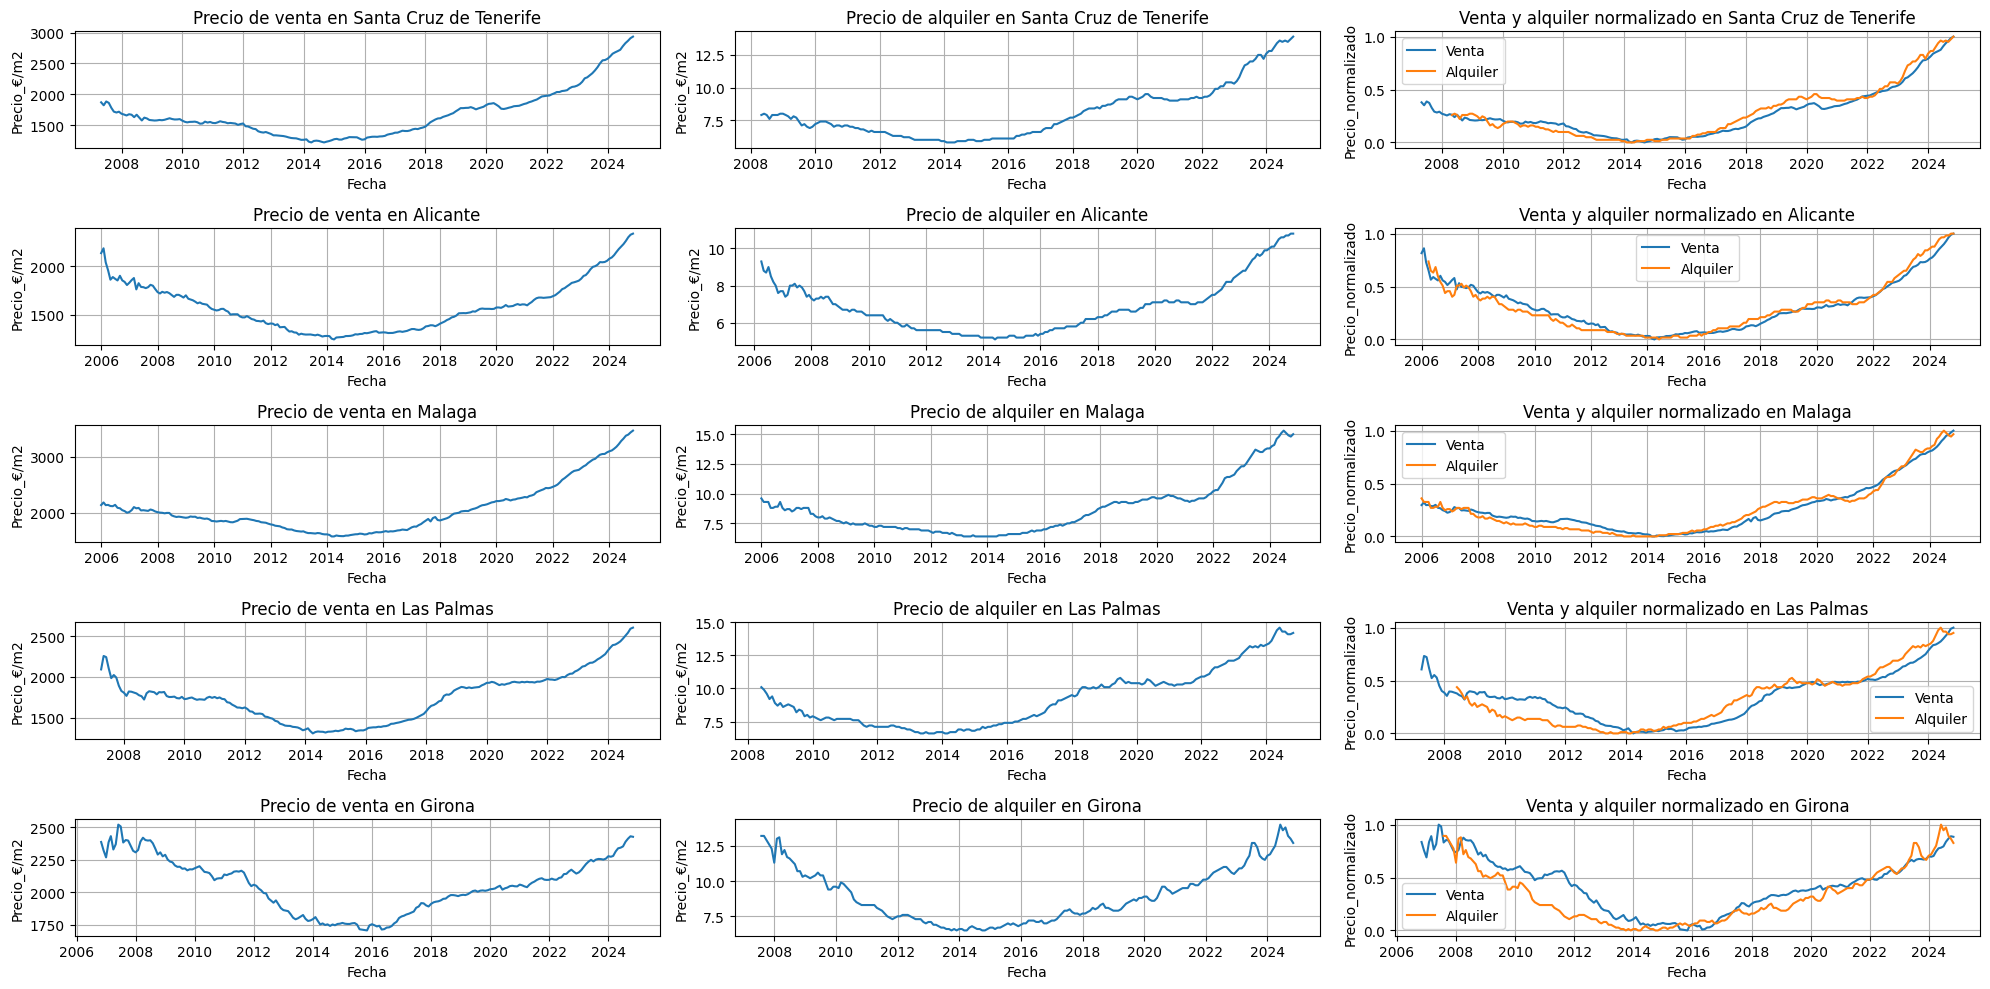

In [13]:
fig, ax = plt.subplots(5,3, figsize = (20,10))

for index, provincia in enumerate(lista_provincias_mayor_correlacion_precios):

    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Precio de venta en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Precio de alquiler en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,2])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,2].grid(True)
plt.tight_layout()
plt.plot()

[]

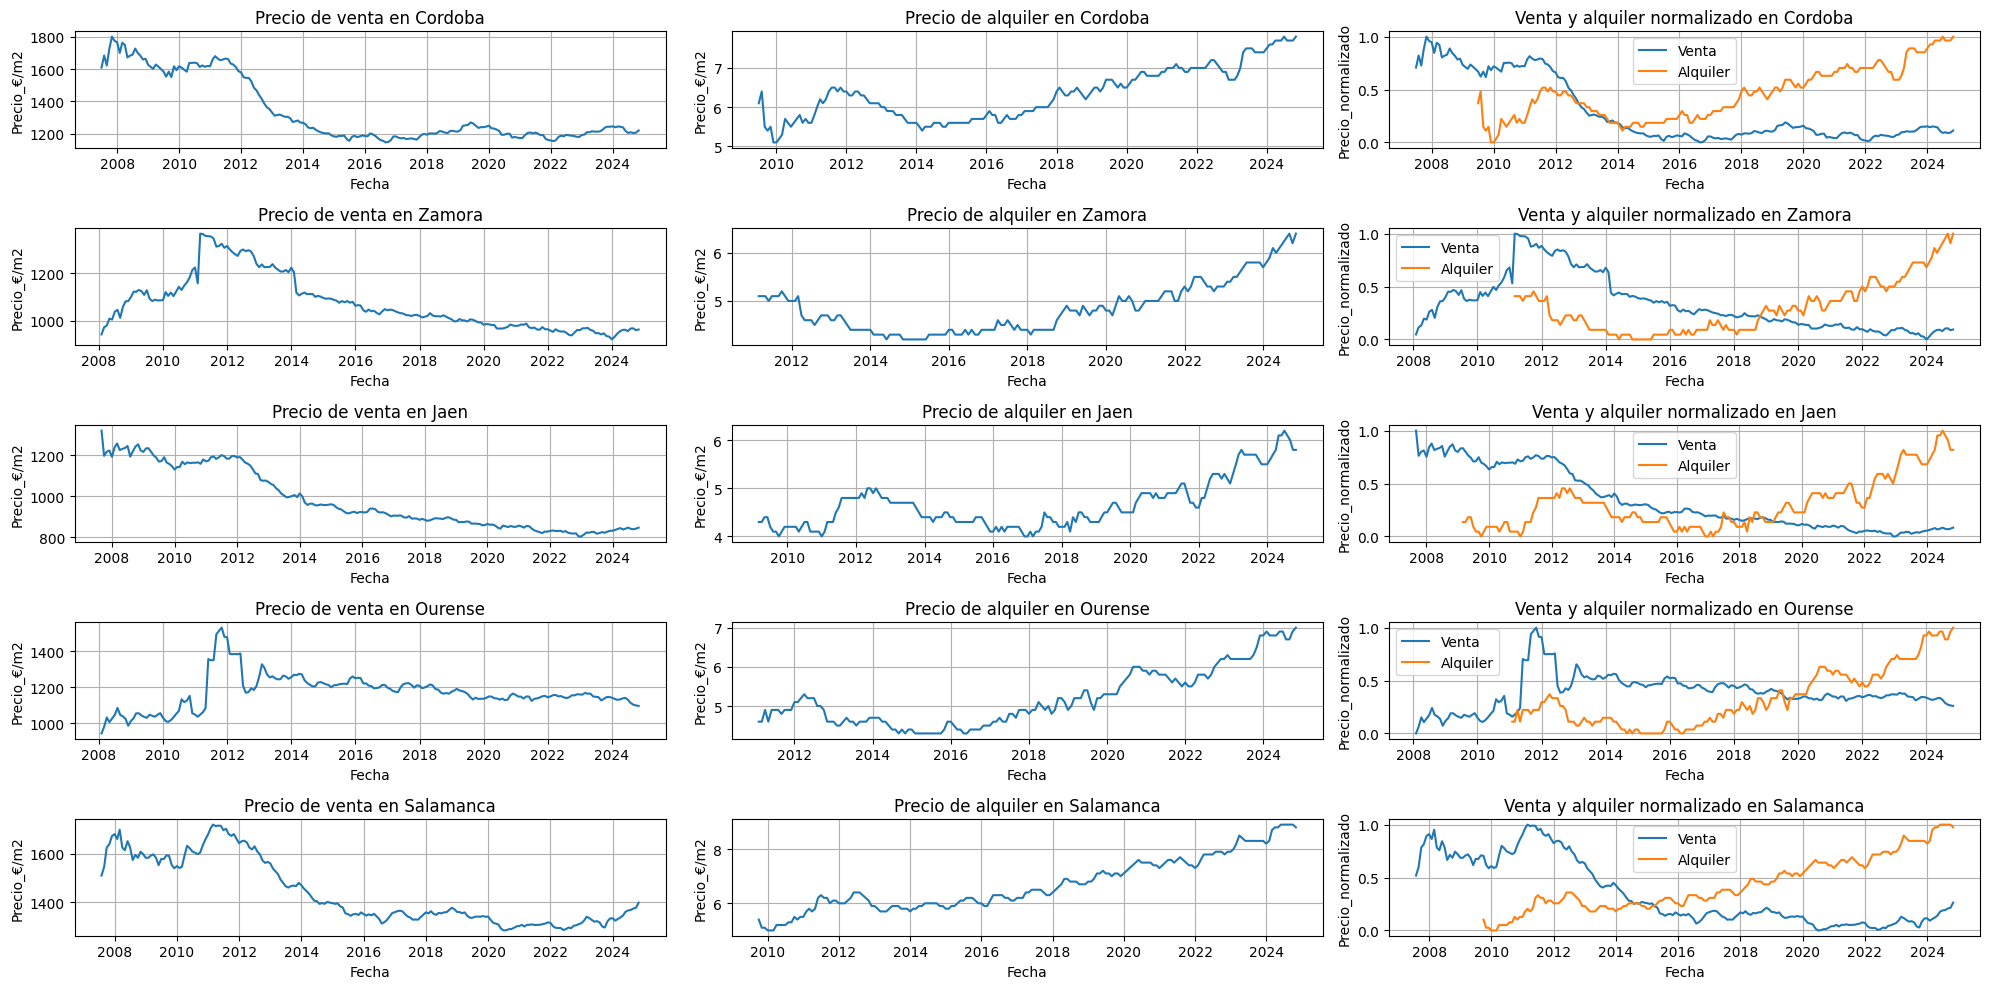

In [14]:
fig, ax = plt.subplots(5,3, figsize = (20,10))

for index, provincia in enumerate(lista_provincias_menor_correlacion_precios):

    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Precio de venta en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Precio de alquiler en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,2])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,2].grid(True)
plt.tight_layout()
plt.plot()

#### 3.1.1 Observaciones  

De este primer análisis, podemos ver:  
- El precio del alquiler aumenta desde 2014-2016 en todas las provincias, independientemente del precio de venta.  
- El precio de venta aumenta sólo en las provincias del primer grupo y se estanca en las del segundo grupo. 
- En los gráficos anteriores se observa que en las provincias del primer grupo el precio de venta es más elevado que en las del segundo grupo.
- En general aunque con alguna excepción, las viviendas pasaron de unos precios elevados de venta y alquiler en los años 2008 y 2012 a unos mínimos entre 2014-2016. Esto se debe a la burbuja existente en los precios antes de la crisis económica de 2008

Los motivos detrás de esto se va a intentar determinar de los análisis siguientes.  

Desde el punto de vista de un inversor:

- En el primer grupo de provincias, si la tendencia se mantiene, comprar una vivienda para alquilar resultará más caro pero el valor propio de la vivienda también crecerá con el tiempo.
- En el segundo grupo de provincias, tenemos un precio de la vivienda más asequible y un alquiler también creciente, pero con un precio del inmueble estancado.

### 3.2 Provincias con mayor crecimiento en precio de venta y alquiler

Usando las observaciones del análisis anterior, vamos a proceder al análisis del crecimiento en los precios de la vivienda centrándonos en el intervalo 2016-2024. De esta menera la realidad estará mejor representada, pues hay provincias en las que el precio ha regresado o superado niveles de 2008, mientras que otras aún están por debajo de estos valores.

In [15]:
df_venta_3_2 = df_venta[df_venta["Fecha"] >= "2016-01-01"]
df_alquiler_3_2 = df_alquiler[df_alquiler["Fecha"] >= "2016-01-01"]

In [17]:
incremento_precio_venta_porcentual = (((df_venta_3_2.groupby("Provincia")["Precio_€/m2"].max() - df_venta_3_2.groupby("Provincia")["Precio_€/m2"].min()) / df_venta_3_2.groupby("Provincia")["Precio_€/m2"].min())*100).sort_values(ascending=False)
incremento_precio_venta_porcentual

Provincia
Islas Baleares            137.626775
Santa Cruz de Tenerife    131.205674
Malaga                    109.041591
Las Palmas                 92.392910
Alicante                   77.972561
Madrid                     73.864169
Ceuta                      49.382716
Lleida                     48.437500
Valencia                   46.282528
Cadiz                      43.902439
Girona                     42.056075
Barcelona                  38.664674
Murcia                     37.272727
Tarragona                  36.554622
Guipuzcoa                  34.693878
Alava                      34.665166
Guadalajara                32.081218
Granada                    30.721831
Navarra                    30.249633
Castellon                  28.752437
Huelva                     27.536232
Segovia                    25.493885
La Rioja                   24.007387
Zaragoza                   23.352319
Toledo                     23.333333
Soria                      23.132780
Almeria                    2

In [18]:
incremento_precio_alquiler_porcentual = (((df_alquiler_3_2.groupby("Provincia")["Precio_€/m2"].max() - df_alquiler_3_2.groupby("Provincia")["Precio_€/m2"].min()) / df_alquiler_3_2.groupby("Provincia")["Precio_€/m2"].min())*100).sort_values(ascending=False)
incremento_precio_alquiler_porcentual

Provincia
Islas Baleares            136.904762
Santa Cruz de Tenerife    127.868852
Valencia                  125.454545
Malaga                    118.571429
Segovia                   107.843137
Girona                    102.898551
Caceres                   102.500000
Alicante                  100.000000
Las Palmas                 97.297297
Cantabria                  95.081967
Lleida                     94.339623
Toledo                     85.714286
Ceuta                      83.582090
Huelva                     83.333333
Castellon                  82.608696
Avila                      82.051282
Cuenca                     78.048780
Guadalajara                77.551020
Madrid                     77.358491
Barcelona                  76.785714
Murcia                     75.510204
A Coruna                   74.509804
Pontevedra                 71.666667
Lugo                       71.428571
Granada                    69.090909
Almeria                    68.750000
La Rioja                   6

En este punto, no podemos sacar más conclusiones analizando únicamente los precios. Apuntamos estas provincias para analizarlas en conjunto con otras variables posteriormente. Nos quedamos con las 5 con mayor y menor incremento de cada lista y las combinamos porque hay alguna que coinciden y se repiten.

In [19]:
lista_provincias_mayor_crecimiento_venta = incremento_precio_venta_porcentual.index[0:5]
lista_provincias_mayor_crecimiento_alquiler = incremento_precio_alquiler_porcentual.index[0:5]
lista_provincias_menor_crecimiento_venta = incremento_precio_venta_porcentual.index[-6:-1]
lista_provincias_menor_crecimiento_alquiler = incremento_precio_alquiler_porcentual.index[-6:-1]

In [20]:
lista_mayor_crecimiento = list(set(lista_provincias_mayor_crecimiento_venta.append(lista_provincias_mayor_crecimiento_alquiler)))
lista_menor_crecimiento = list(set(lista_provincias_menor_crecimiento_venta.append(lista_provincias_menor_crecimiento_alquiler)))

print(lista_mayor_crecimiento)
print()
print(lista_menor_crecimiento)

del df_venta_3_2
del df_alquiler_3_2

['Valencia', 'Malaga', 'Segovia', 'Las Palmas', 'Islas Baleares', 'Santa Cruz de Tenerife', 'Alicante']

['Salamanca', 'Burgos', 'Cordoba', 'Palencia', 'Ciudad Real', 'Zamora', 'Asturias', 'Vizcaya']


### 3.3. Número de viajeros (Turismo)

En este apartado vamos a identificar las provincias con mayor y menor número de turistas para ver como esta variable puede afectar al precio.   
Para eliminar el efecto del Covid y la estacionalidad, vamos a usar el valor promedio de los datos a partir de enero de 2021

In [21]:
df_turismo[df_turismo["Fecha"] >= "2021-01-01"].groupby(["Provincia"])["Viajeros"].median().sort_values(ascending=False)

Provincia
Las Palmas                159454.5
Santa Cruz de Tenerife    105211.5
Malaga                     93174.5
Alicante                   83584.5
Islas Baleares             64106.0
Madrid                     59603.5
Sevilla                    39496.0
Valencia                   32443.5
Granada                    28133.0
Barcelona                  23627.5
Tarragona                  21058.5
Cadiz                      19251.5
Girona                     18035.5
Castellon                  12994.5
Almeria                    10023.0
Cantabria                   9342.5
Murcia                      9308.0
Salamanca                   8894.5
Caceres                     8447.0
Navarra                     7953.0
A Coruna                    7771.5
Vizcaya                     7437.5
Huesca                      7311.5
Cordoba                     6400.5
Guipuzcoa                   5852.0
Badajoz                     5663.5
Asturias                    5420.0
Jaen                        5321.5
La Rioja  

In [22]:
lista_provincias_mas_turistas = list(df_turismo[df_turismo["Fecha"] >= "2021-01-01"].groupby(["Provincia"])["Viajeros"].median().sort_values(ascending=False).index)[0:5]
lista_provincias_menos_turistas = list(df_turismo[df_turismo["Fecha"] >= "2021-01-01"].groupby(["Provincia"])["Viajeros"].median().sort_values(ascending=False).index)[-6:-1]

In [23]:
print(lista_provincias_mas_turistas)
print()
print(lista_provincias_menos_turistas)

['Las Palmas', 'Santa Cruz de Tenerife', 'Malaga', 'Alicante', 'Islas Baleares']

['Zamora', 'Ciudad Real', 'Alava', 'Ourense', 'Soria']


Procedemos ahora a representar los datos para sacar conclusiones:

[]

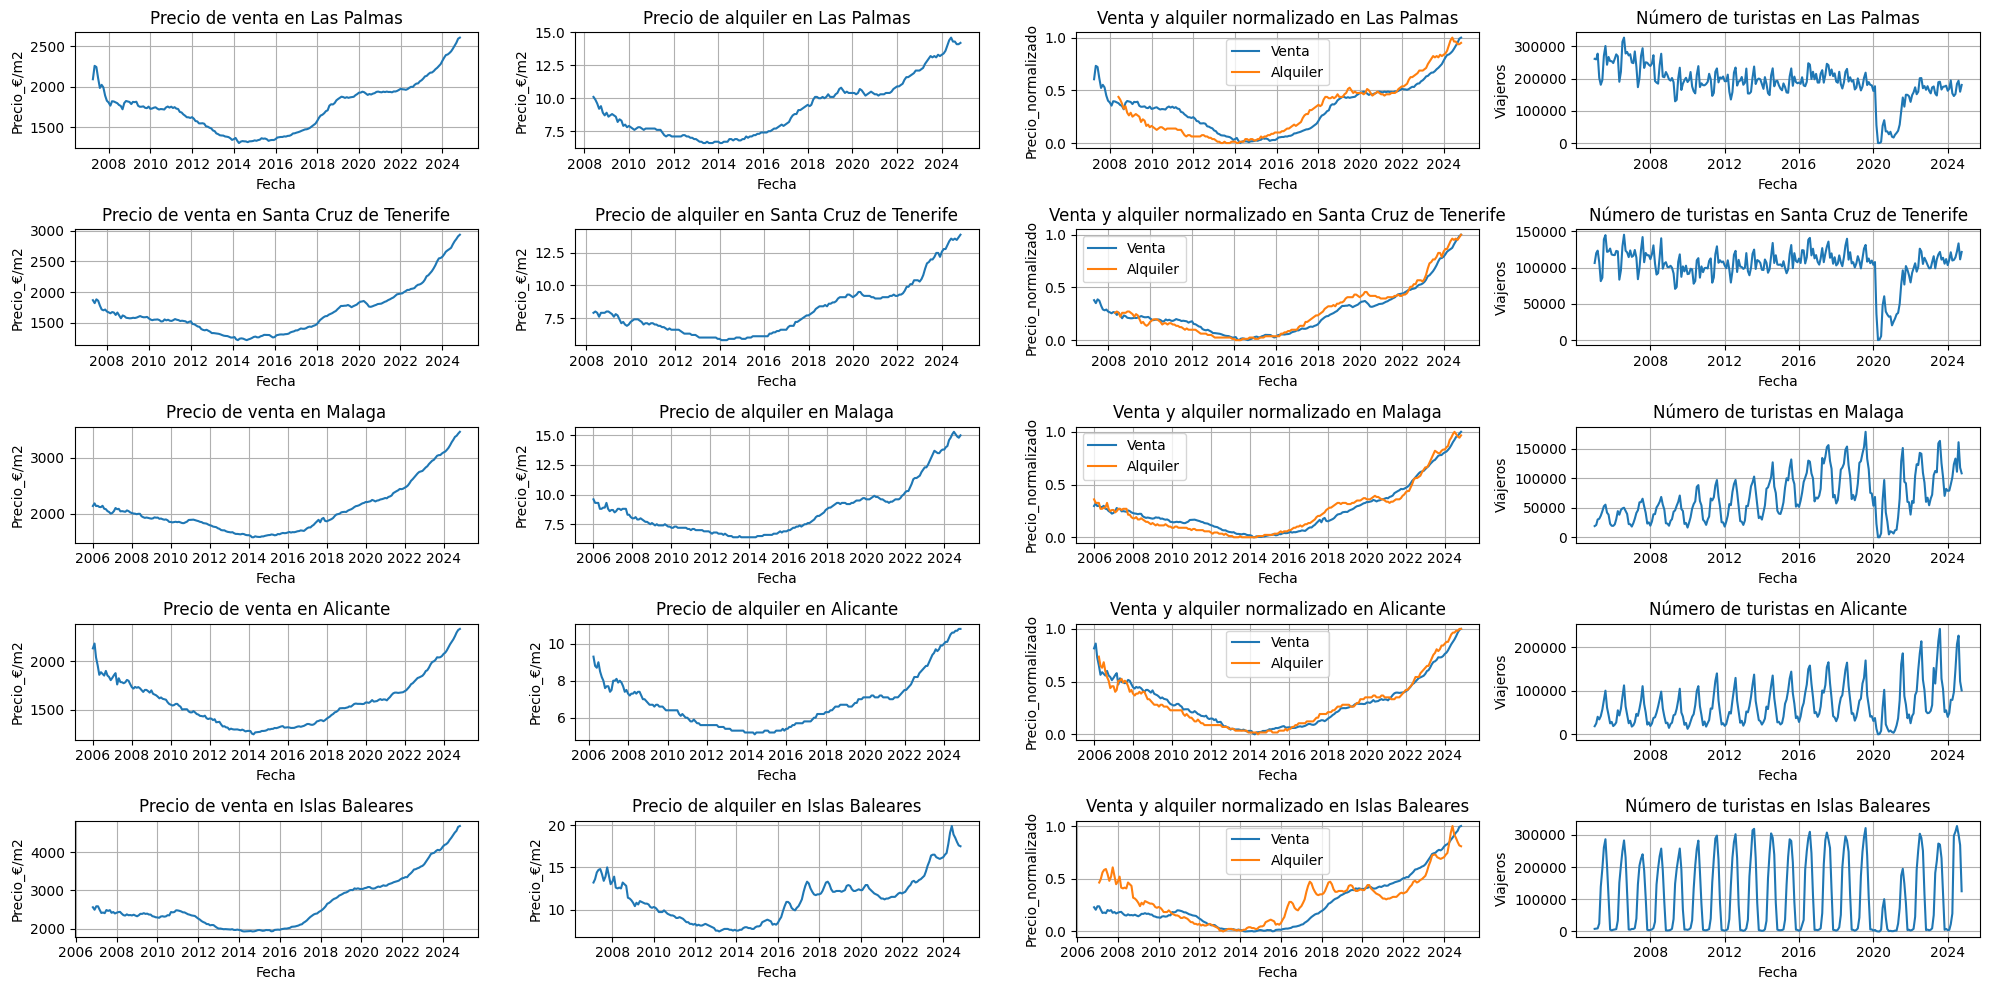

In [24]:
fig, ax = plt.subplots(5,4, figsize = (20,10))

for index, provincia in enumerate(lista_provincias_mas_turistas):

    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Precio de venta en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Precio de alquiler en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,2])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,2].grid(True)
    sns.lineplot(data = df_turismo[df_turismo["Provincia"] == provincia], x = "Fecha", y = "Viajeros", errorbar= None, ax = ax[index,3])
    ax[index,3].set_title("Número de turistas en " + provincia)
    ax[index,3].grid(True)
plt.tight_layout()
plt.plot()

[]

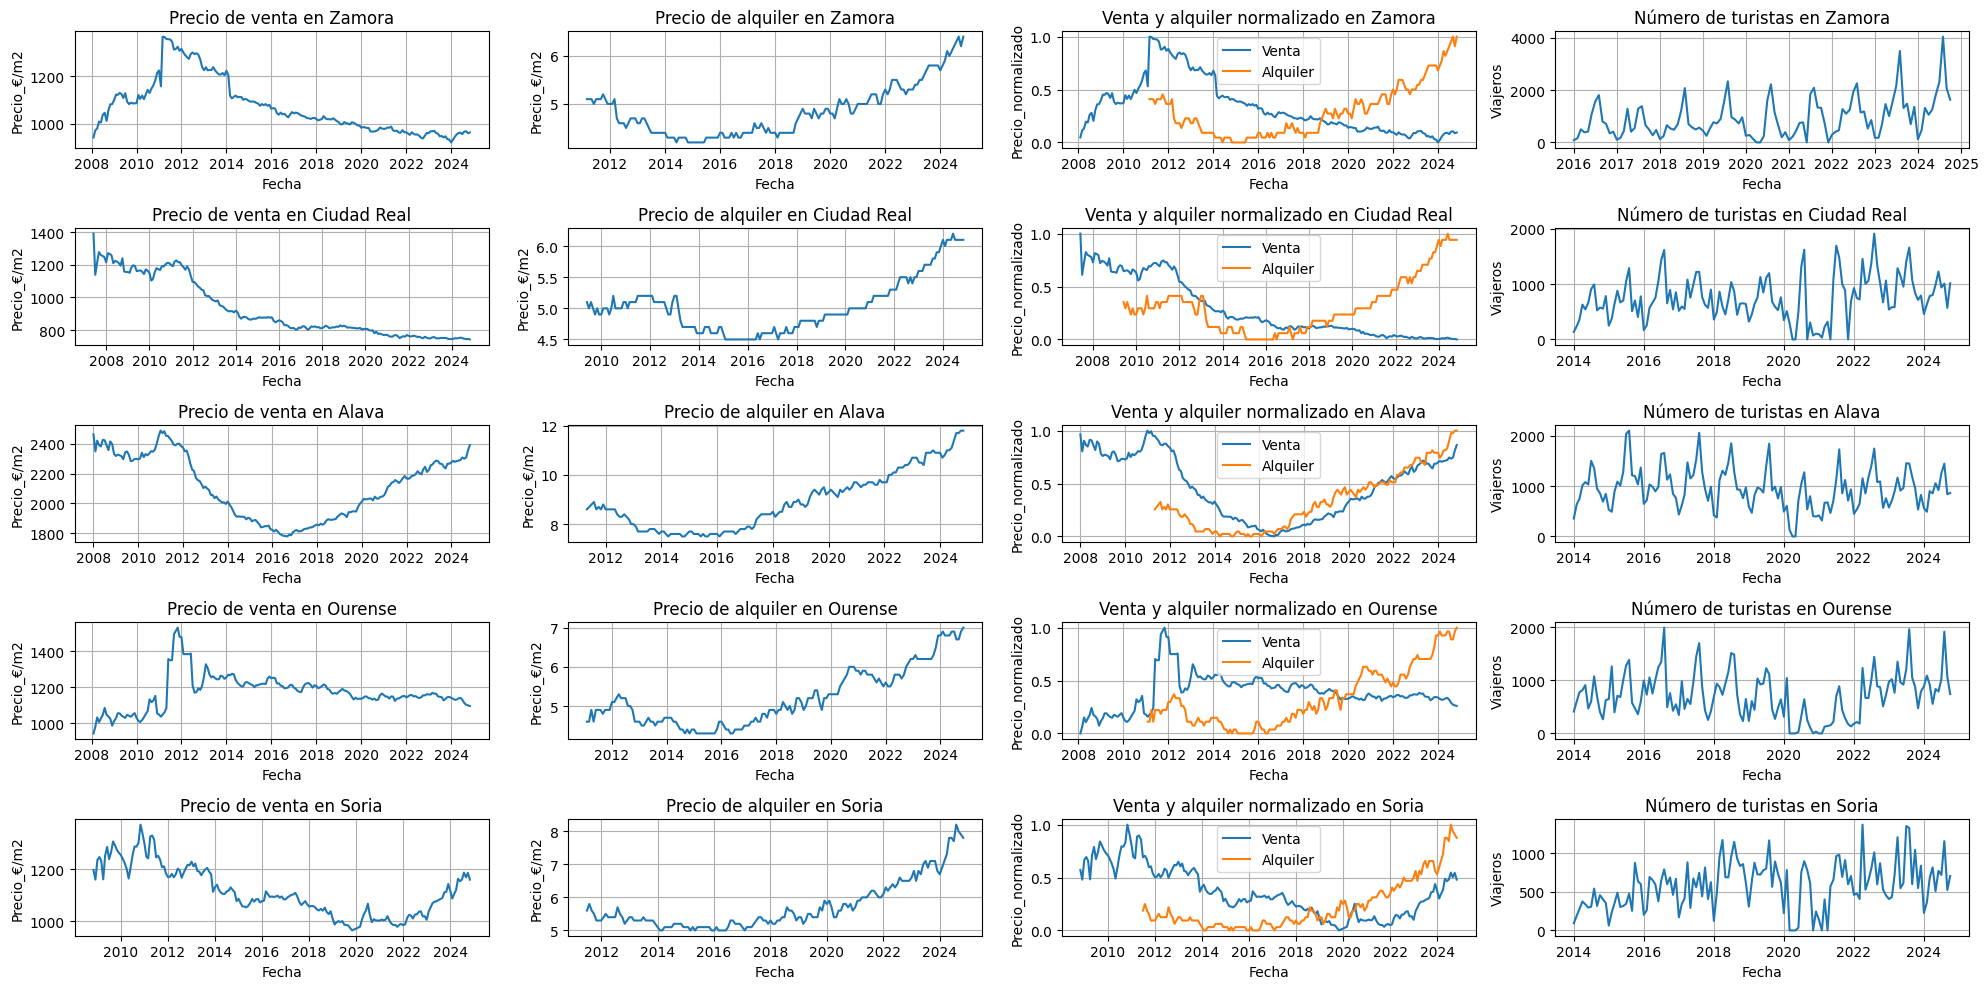

In [25]:
fig, ax = plt.subplots(5,4, figsize = (20,10))

for index, provincia in enumerate(lista_provincias_menos_turistas):

    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Precio de venta en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Precio de alquiler en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,2])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,2].grid(True)
    sns.lineplot(data = df_turismo[df_turismo["Provincia"] == provincia], x = "Fecha", y = "Viajeros", errorbar= None, ax = ax[index,3])
    ax[index,3].set_title("Número de turistas en " + provincia)
    ax[index,3].grid(True)
plt.tight_layout()
plt.plot()

#### 3.3.1. Observaciones  

En vista a lo anterior:

- El precio de venta aumenta en todas las provincias con alto número de turistas, pero también crece en algunas con pocos turistas, mientras que no lo hace en otras de este grupo. Parece que el turismo no es tan determinante a la hora de afectar al precio de venta. Habría que resolver nuevas hipótesis, como puede ser que el hecho de que el alquiler suba en las provincias con mayor número de turismo las hace más atractiva para la inversión.
- El precio del alquiler sube tanto en aquellas provincias con mayor número de turistas como en las que menos. Sin embargo, es cierto que el precio crece más rápido en aquellas provincias en las que el número de turistas es mayor, por lo que sí que afecta al ritmo de crecimiento. Vamos a verlo numéricamente:
 

In [26]:
df_alquiler_mas_turistas = df_alquiler[df_alquiler["Provincia"].isin(lista_provincias_mas_turistas)]
df_alquiler_menos_turistas = df_alquiler[df_alquiler["Provincia"].isin(lista_provincias_menos_turistas)]

In [27]:
(((df_alquiler_mas_turistas.groupby("Provincia")["Precio_€/m2"].max() - df_alquiler_mas_turistas.groupby("Provincia")["Precio_€/m2"].min()) / df_alquiler_mas_turistas.groupby("Provincia")["Precio_€/m2"].min())*100).sort_values(ascending=False)

Provincia
Islas Baleares            168.918919
Santa Cruz de Tenerife    139.655172
Malaga                    139.062500
Las Palmas                121.212121
Alicante                  111.764706
Name: Precio_€/m2, dtype: float64

In [28]:
(((df_alquiler_menos_turistas.groupby("Provincia")["Precio_€/m2"].max() - df_alquiler_menos_turistas.groupby("Provincia")["Precio_€/m2"].min()) / df_alquiler_menos_turistas.groupby("Provincia")["Precio_€/m2"].min())*100).sort_values(ascending=False)

Provincia
Soria          64.000000
Ourense        62.790698
Alava          57.333333
Zamora         52.380952
Ciudad Real    37.777778
Name: Precio_€/m2, dtype: float64

Como hemos comentado, el precio del alquiler se ha más que duplicado en las provincias con más turistas, pero "sólo" ha aumentado entre un 37% y un 64% en las provincias menos turísticas

### 3.4. Población residente

De manera análoga al punto anterior, se va a proceder a crear una lista para las provincias con mayor y menor crecimiento poblacional.  En este caso, se van a tomar los números de habitantes correspondientes al primer y último mes disponibles de la serie.

In [29]:
df_poblacion.head()

Provincia      Fecha  Poblacion           Comunidad  Poblacion_normalizado
0  Albacete 2023-01-01   387529.0  Castilla-La Mancha               0.224520
1  Albacete 2022-10-01   386929.0  Castilla-La Mancha               0.191430
2  Albacete 2022-07-01   386330.0  Castilla-La Mancha               0.158394
3  Albacete 2022-04-01   386047.0  Castilla-La Mancha               0.142786
4  Albacete 2022-01-01   385967.0  Castilla-La Mancha               0.138374

Vemos primero si el valor de datos más antiguo de la serie está disponible para todas las provincias. Debe salir una lista de 52 filas:

In [30]:
len(df_poblacion[df_poblacion["Fecha"] == df_poblacion["Fecha"].min()])

52

Igual para la fecha más reciente:

In [31]:
len(df_poblacion[df_poblacion["Fecha"] == df_poblacion["Fecha"].max()])

52

Procedemos ahora a calcular el incremento poblacional en porcentaje:

In [32]:
df_crecimiento_poblacion = ((df_poblacion[df_poblacion["Fecha"] == df_poblacion["Fecha"].max()][["Provincia", "Poblacion"]].sort_values(by="Provincia").set_index("Provincia") - \
df_poblacion[df_poblacion["Fecha"] == df_poblacion["Fecha"].min()][["Provincia", "Poblacion"]].sort_values(by="Provincia").set_index("Provincia")) / \
df_poblacion[df_poblacion["Fecha"] == df_poblacion["Fecha"].min()][["Provincia", "Poblacion"]].sort_values(by="Provincia").set_index("Provincia")) *100

In [33]:
df_crecimiento_poblacion = df_crecimiento_poblacion.sort_values(by="Poblacion", ascending=False)
df_crecimiento_poblacion


Poblacion
Provincia                        
Guadalajara             29.045908
Melilla                 27.392341
Islas Baleares          24.695554
Girona                  20.893811
Malaga                  20.372808
Almeria                 20.016122
Toledo                  19.504337
Tarragona               18.114603
Santa Cruz de Tenerife  17.557643
Las Palmas              15.529097
Madrid                  15.424254
Murcia                  14.845804
Alicante                14.080706
Ceuta                   14.073016
Navarra                 13.511702
Lleida                  11.373272
Alava                   11.183182
Barcelona               11.021156
Castellon               10.159289
Valencia                 9.844464
Huelva                   9.325156
Sevilla                  8.375300
Granada                  7.167877
Zaragoza                 7.029630
Cadiz                    6.645443
La Rioja                 6.470167
Guipuzcoa                5.561842
Cantabria                4.873967
Huesca                   4.433203
Pontevedra               2.023750
Valladolid               1.475812
Vizcaya                  1.452894
Albacete                 1.061655
A Coruna                 0.759269
Badajoz                 -0.368132
Segovia                 -0.603423
Cordoba                 -0.727187
Burgos                  -0.921557
Ciudad Real             -1.794512
Soria                   -3.459282
Teruel                  -4.413191
Caceres                 -4.469022
Cuenca                  -4.653085
Avila                   -4.874070
Asturias                -5.399967
Jaen                    -5.466501
Salamanca               -5.547229
Lugo                    -8.041710
Leon                    -8.179779
Palencia                -8.496387
Ourense                 -8.848133
Zamora                 -14.832729

In [34]:
lista_provincias_mayor_aumento_poblacion = list(df_crecimiento_poblacion.index[0:5])
lista_provincias_disminucion_poblacion = list(df_crecimiento_poblacion.index[-6:-1])

del df_crecimiento_poblacion

print(lista_provincias_mayor_aumento_poblacion)
print()
print(lista_provincias_disminucion_poblacion)

['Guadalajara', 'Melilla', 'Islas Baleares', 'Girona', 'Malaga']

['Salamanca', 'Lugo', 'Leon', 'Palencia', 'Ourense']


[]

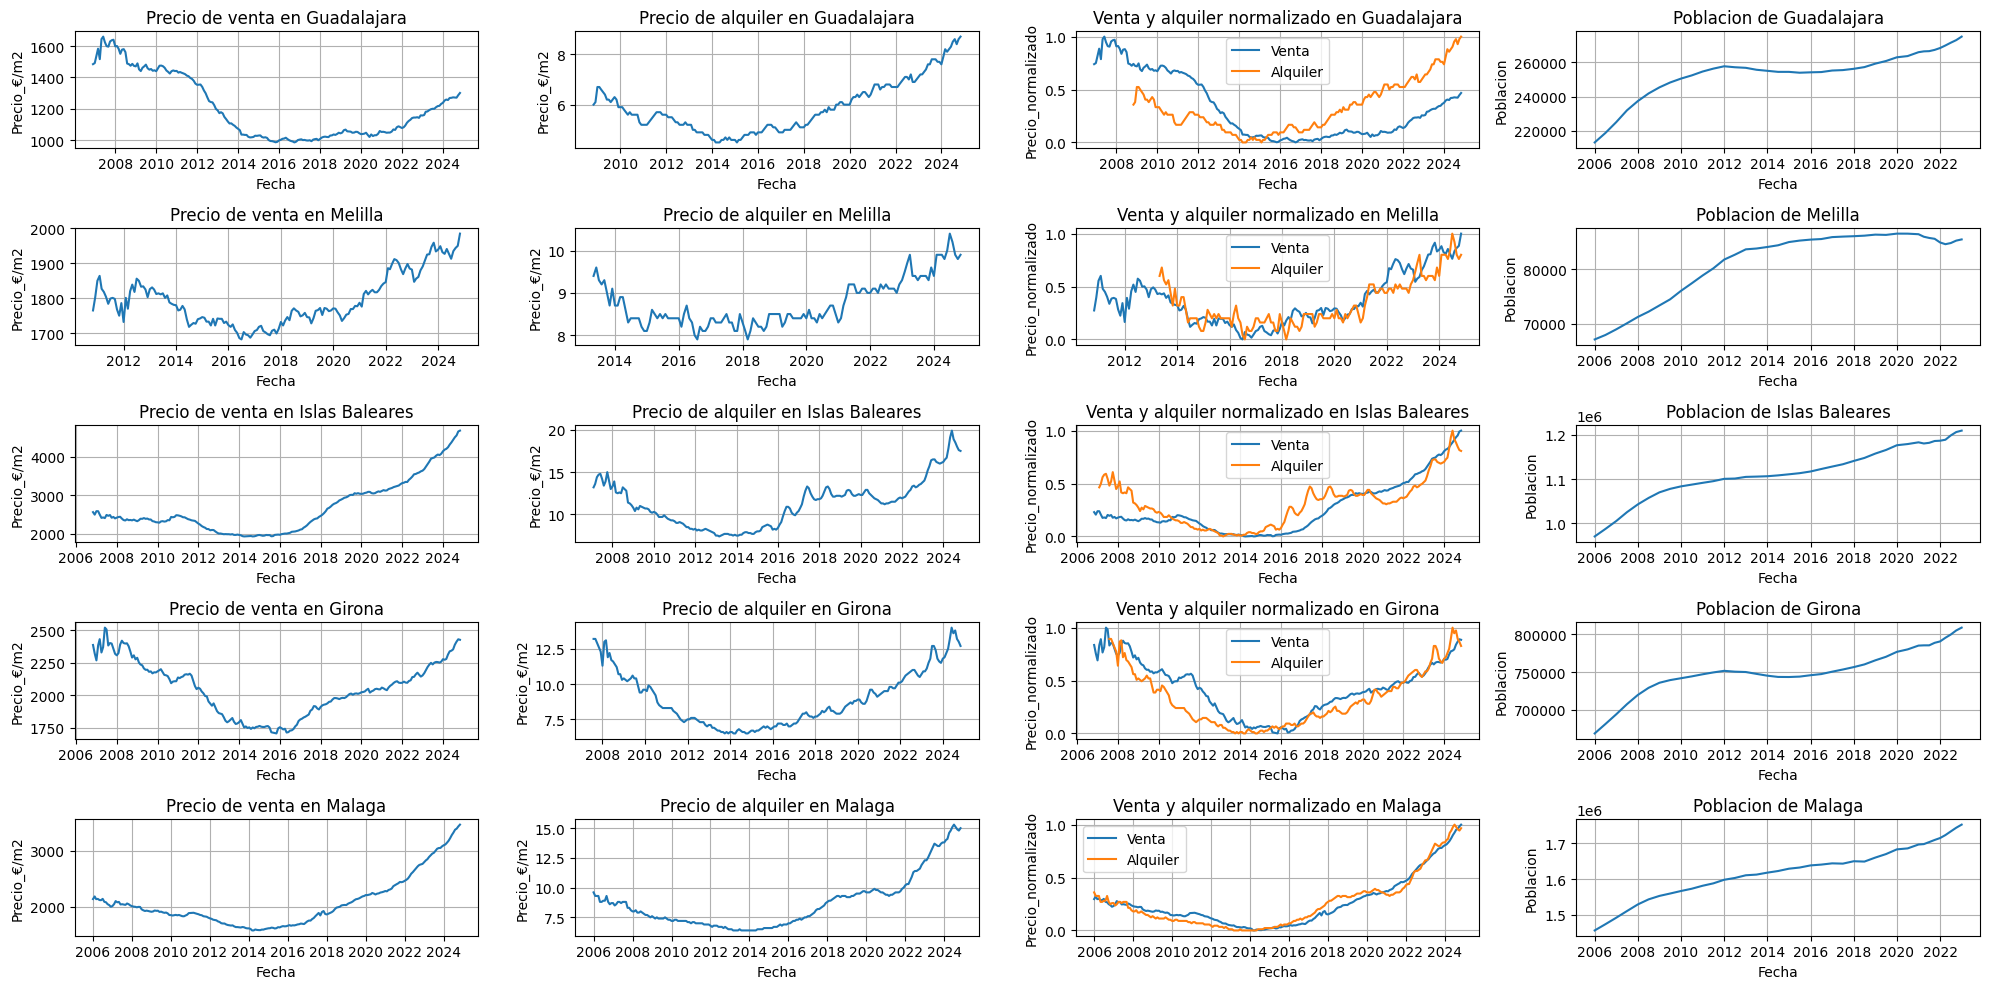

In [35]:
fig, ax = plt.subplots(5,4, figsize = (20,10))

for index, provincia in enumerate(lista_provincias_mayor_aumento_poblacion):

    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Precio de venta en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Precio de alquiler en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,2])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,2].grid(True)
    sns.lineplot(data = df_poblacion[df_poblacion["Provincia"] == provincia], x = "Fecha", y = "Poblacion", errorbar= None, ax = ax[index,3])
    ax[index,3].set_title("Poblacion de " + provincia)
    ax[index,3].grid(True)
plt.tight_layout()
plt.plot()

[]

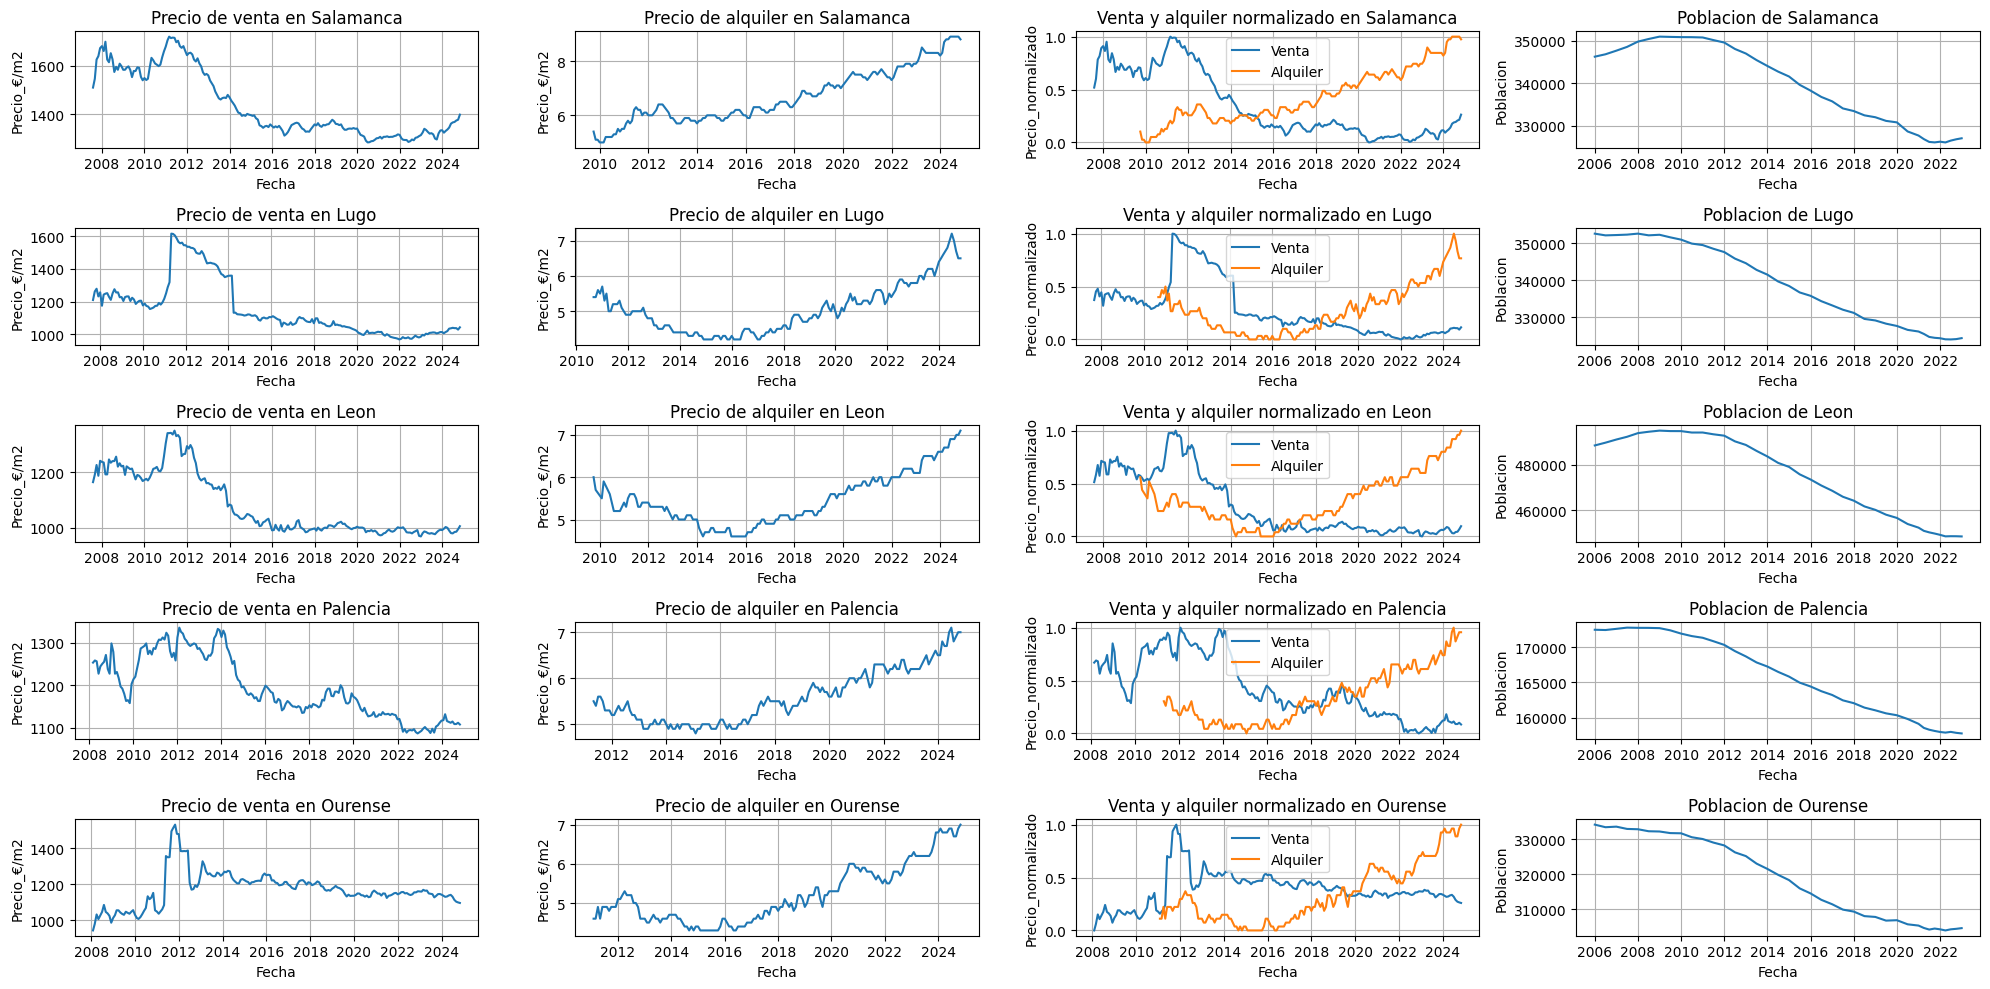

In [36]:
fig, ax = plt.subplots(5,4, figsize = (20,10))

for index, provincia in enumerate(lista_provincias_disminucion_poblacion):

    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Precio de venta en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Precio de alquiler en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,2])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,2].grid(True)
    sns.lineplot(data = df_poblacion[df_poblacion["Provincia"] == provincia], x = "Fecha", y = "Poblacion", errorbar= None, ax = ax[index,3])
    ax[index,3].set_title("Poblacion de " + provincia)
    ax[index,3].grid(True)
plt.tight_layout()
plt.plot()

#### 3.4.1. Observaciones

A nivel gráfico, sin necesidad de cálculos adicionales, se puede observar:  

- El precio de venta parece verse afectado por el incremento/decremiento de la población. Entre las provincias con mayor crecimiento poblacional, el precio de venta de viviendas también aumenta. En las provincias en las que la población decrece, el precio de venta también decrece.
- El precio del alquiler sube en todas las provincias, por lo que debe deberse a un factor distinto.

### 3.5. Salarios (mediano)

Se va a proceder a crear una lista para las provincias con mayor y menor crecimiento salarial.

In [37]:
df_crecimiento_salarial = ((df_salarios[df_salarios["Fecha"] == df_salarios["Fecha"].max()][["Provincia", "Salario"]].sort_values(by="Provincia").set_index("Provincia") - \
df_salarios[df_salarios["Fecha"] == df_salarios["Fecha"].min()][["Provincia", "Salario"]].sort_values(by="Provincia").set_index("Provincia")) / \
df_salarios[df_salarios["Fecha"] == df_salarios["Fecha"].min()][["Provincia", "Salario"]].sort_values(by="Provincia").set_index("Provincia")) *100

In [38]:
df_crecimiento_salarial = df_crecimiento_salarial.sort_values(by="Salario", ascending=False)
df_crecimiento_salarial

Salario
Provincia                        
Islas Baleares          37.595908
A Coruna                26.914742
Ourense                 26.914742
Pontevedra              26.914742
Lugo                    26.914742
Guipuzcoa               24.684583
Vizcaya                 24.684583
Alava                   24.684583
Barcelona               24.457395
Girona                  24.457395
Lleida                  24.457395
Tarragona               24.457395
Madrid                  24.336458
La Rioja                23.643911
Cuenca                  23.502804
Guadalajara             23.502804
Ciudad Real             23.502804
Albacete                23.502804
Toledo                  23.502804
Navarra                 23.228825
Castellon               23.155835
Alicante                23.155835
Valencia                23.155835
Asturias                23.018505
Cantabria               22.808511
Las Palmas              22.187599
Santa Cruz de Tenerife  22.187599
Murcia                  21.945840
Caceres                 21.450190
Badajoz                 21.450190
Avila                   19.893315
Soria                   19.893315
Zamora                  19.893315
Burgos                  19.893315
Valladolid              19.893315
Leon                    19.893315
Segovia                 19.893315
Salamanca               19.893315
Palencia                19.893315
Huesca                  19.119728
Zaragoza                19.119728
Teruel                  19.119728
Cordoba                 14.460051
Cadiz                   14.460051
Almeria                 14.460051
Jaen                    14.460051
Malaga                  14.460051
Granada                 14.460051
Huelva                  14.460051
Sevilla                 14.460051

In [39]:
lista_provincias_mayor_crecimiento_salarial = list(df_crecimiento_salarial.index[0:5])
lista_provincias_menor_crecimiento_salarial = list(df_crecimiento_salarial.index[-6:-1])

del df_crecimiento_salarial

print(lista_provincias_mayor_crecimiento_salarial)
print()
print(lista_provincias_menor_crecimiento_salarial)

['Islas Baleares', 'A Coruna', 'Ourense', 'Pontevedra', 'Lugo']

['Almeria', 'Jaen', 'Malaga', 'Granada', 'Huelva']


[]

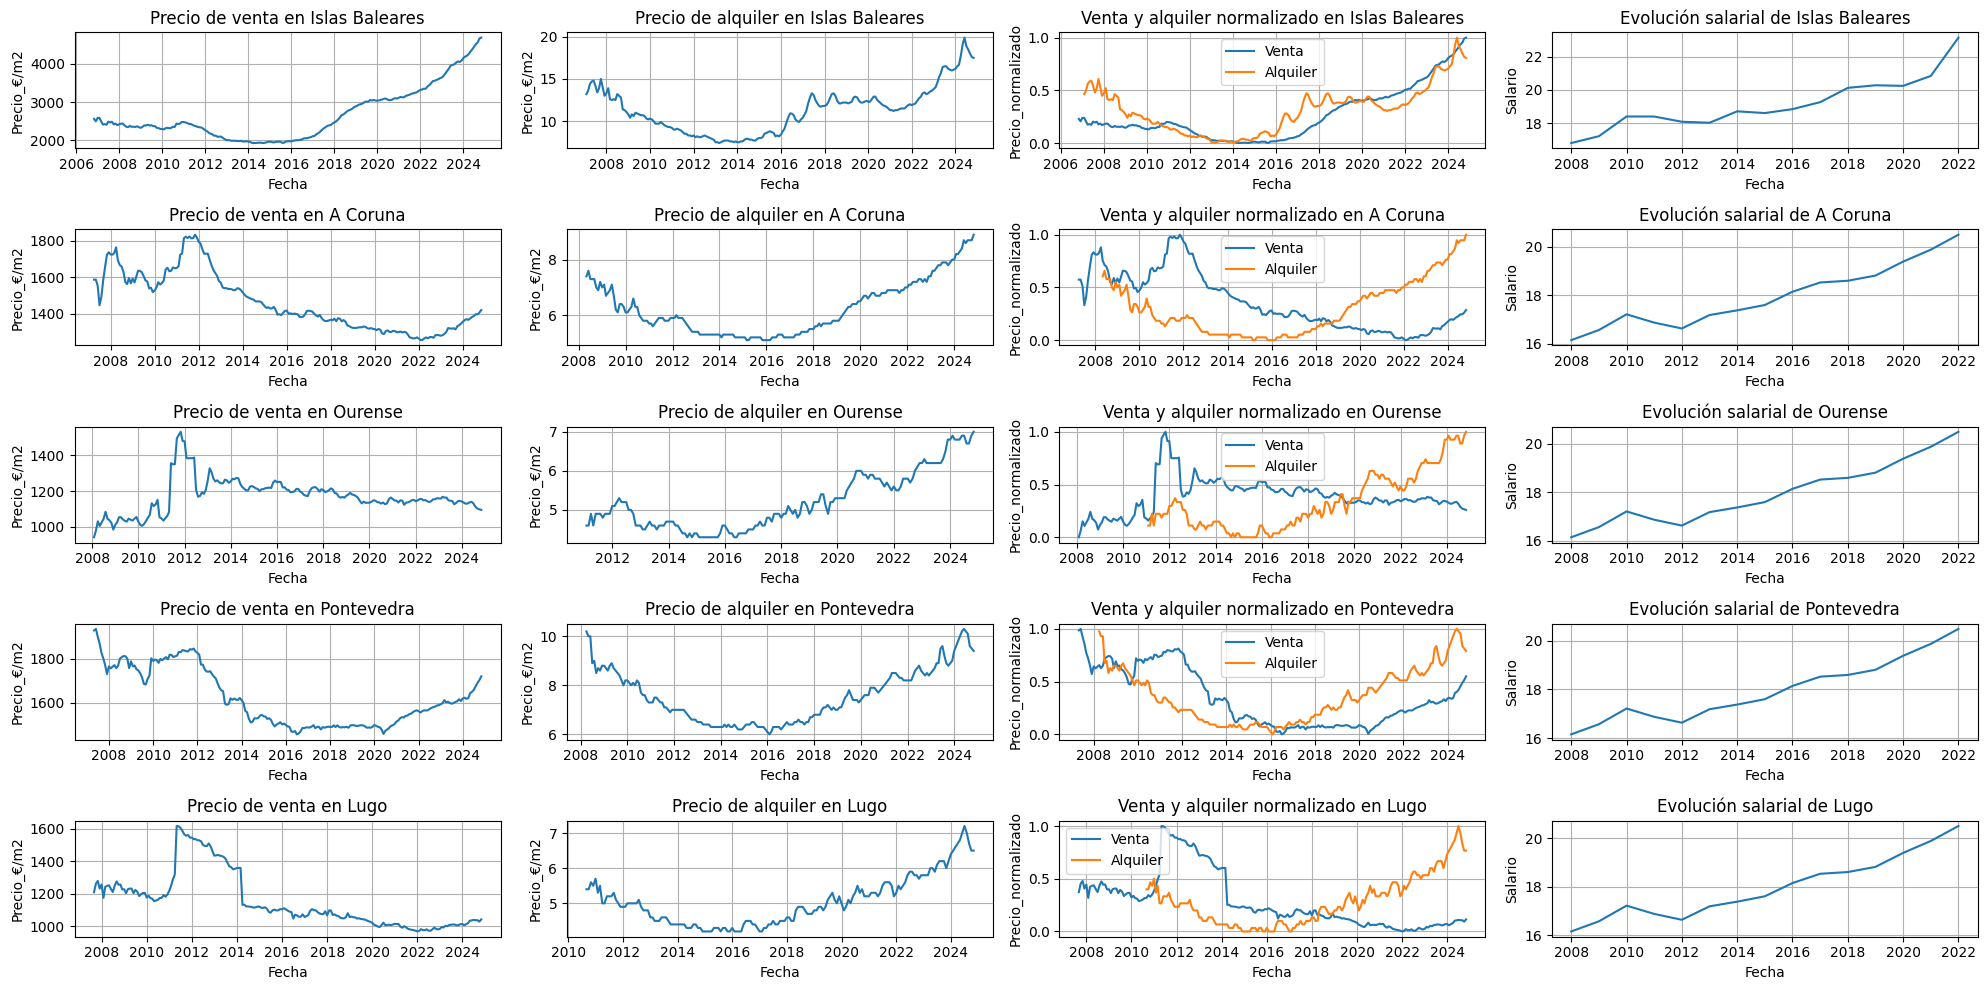

In [40]:
fig, ax = plt.subplots(5,4, figsize = (20,10))

for index, provincia in enumerate(lista_provincias_mayor_crecimiento_salarial):

    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Precio de venta en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Precio de alquiler en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,2])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,2].grid(True)
    sns.lineplot(data = df_salarios[df_salarios["Provincia"] == provincia], x = "Fecha", y = "Salario", errorbar= None, ax = ax[index,3])
    ax[index,3].set_title("Evolución salarial de " + provincia)
    ax[index,3].grid(True)
plt.tight_layout()
plt.plot()

[]

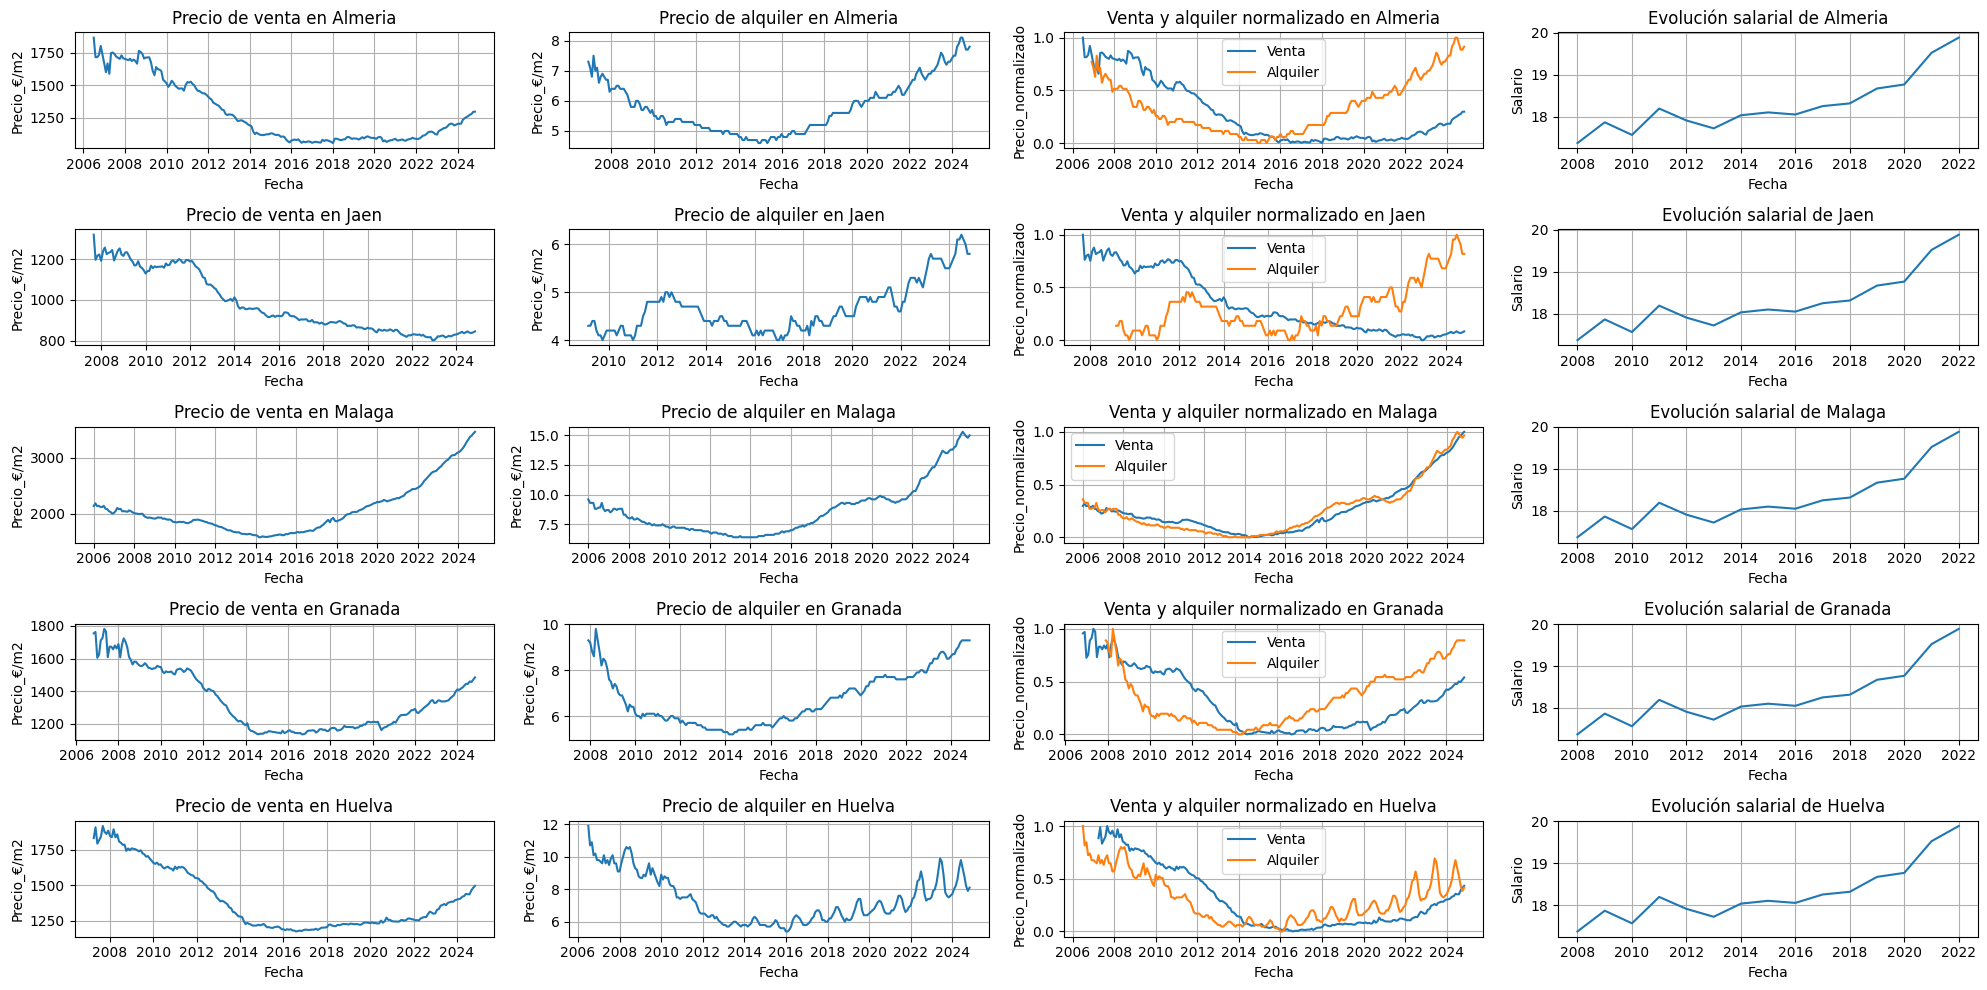

In [41]:
fig, ax = plt.subplots(5,4, figsize = (20,10))

for index, provincia in enumerate(lista_provincias_menor_crecimiento_salarial):

    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Precio de venta en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_€/m2", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Precio de alquiler en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,2])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,2].grid(True)
    sns.lineplot(data = df_salarios[df_salarios["Provincia"] == provincia], x = "Fecha", y = "Salario", errorbar= None, ax = ax[index,3])
    ax[index,3].set_title("Evolución salarial de " + provincia)
    ax[index,3].grid(True)
plt.tight_layout()
plt.plot()

#### 3.5.1. Observaciones  

De los gráficos anteriores, observamos:

- Los salarios suben de forma general en todas las provincias.
- Los precios de venta y alquiler no parecen estar relacionados con la evolución salarial
- De los apartados anteriores, los salarios crecen a un ritmo más lento que los precios de venta y alquiler (los precios crecen a un ritmo entre 3 y 6 veces superior a los salarios)

### 3.6 Vivienda (tensionamiento)  

En este último análisis individual, se va a proceder a analizar el tensionamiento de la vivienda.  
El crecimiento del número de viviendas por si mismo no es relevante, pues es creciente en todas las provincias. Por este motivo, se va a crear un índice de tensionamiento de la vivienda, que va a comparar el crecimiento poblacional con el número de viviendas creadas.  Para ello:  

- Se va a crear un nuevo dataset que usará como punto de partida los datos absolutos (no estandarizados) del crecimiento anual de poblacion y del número de viviendas por provincia.
- Como tienen escalas distintas, se va a trabajar con los incrementos anuales de población y número de viviendas.
- Se va a calcular la diferencia entre el valor del incremento anual de población y número de viviendas.
- Si el resultado de esta diferencia es positivo, indicará que hay un mayor tensionamiento (la población crece más rápido que la creación de viviendas)
- Si el resultado de esta diferencia es negativo, indicará que hay un menor tensionamiento (la población crece más despacio que la creación de viviendas)

In [42]:
df_tensionamiento = pd.merge(left=df_viviendas, right=df_poblacion, on=["Fecha","Provincia"], how="inner")[["Provincia","Fecha","Viviendas","Poblacion"]]
df_tensionamiento

Provincia      Fecha  Viviendas  Poblacion
0    A Coruna 2006-01-01     597309  1115415.0
1    A Coruna 2007-01-01     612717  1121347.0
2    A Coruna 2008-01-01     627888  1128599.0
3    A Coruna 2009-01-01     637487  1135287.0
4    A Coruna 2010-01-01     644022  1138107.0
..        ...        ...        ...        ...
895  Zaragoza 2019-01-01     537014   965673.0
896  Zaragoza 2020-01-01     543799   973740.0
897  Zaragoza 2021-01-01     545762   973684.0
898  Zaragoza 2022-01-01     547525   968884.0
899  Zaragoza 2023-01-01     549179   979365.0

[900 rows x 4 columns]

In [43]:
df_tensionamiento = pd.merge(left=df_viviendas, right=df_poblacion, on=["Fecha","Provincia"], how="inner")[["Provincia","Fecha","Viviendas","Poblacion"]]

df_tensionamiento = df_tensionamiento.sort_values(by=['Provincia', 'Fecha'])

# Calcular el crecimiento en porcentaje de la población con respecto al año anterior
df_tensionamiento['Poblacion_cambio'] = df_tensionamiento.groupby('Provincia')['Poblacion'].pct_change(periods=1) * 100

# Calcular el crecimiento en porcentaje del número de viviendas con respecto al año anterior
df_tensionamiento['Viviendas_cambio'] = df_tensionamiento.groupby('Provincia')['Viviendas'].pct_change(periods=1) * 100

#Creamos el indice de tensionamiento
df_tensionamiento["Indice_tensionamiento"] = df_tensionamiento["Poblacion_cambio"] - df_tensionamiento["Viviendas_cambio"]
df_tensionamiento.dropna(inplace=True)
df_tensionamiento

Provincia      Fecha  Viviendas  Poblacion  Poblacion_cambio  \
1    A Coruna 2007-01-01     612717  1121347.0          0.531820   
2    A Coruna 2008-01-01     627888  1128599.0          0.646722   
3    A Coruna 2009-01-01     637487  1135287.0          0.592593   
4    A Coruna 2010-01-01     644022  1138107.0          0.248395   
5    A Coruna 2011-01-01     647370  1140069.0          0.172392   
..        ...        ...        ...        ...               ...   
895  Zaragoza 2019-01-01     537014   965673.0          0.759815   
896  Zaragoza 2020-01-01     543799   973740.0          0.835376   
897  Zaragoza 2021-01-01     545762   973684.0         -0.005751   
898  Zaragoza 2022-01-01     547525   968884.0         -0.492973   
899  Zaragoza 2023-01-01     549179   979365.0          1.081760   

     Viviendas_cambio  Indice_tensionamiento  
1            2.579569              -2.047749  
2            2.476021              -1.829299  
3            1.528776              -0.936183  
4            1.025119              -0.776724  
5            0.519858              -0.347466  
..                ...                    ...  
895          0.215916               0.543899  
896          1.263468              -0.428092  
897          0.360979              -0.366730  
898          0.323035              -0.816008  
899          0.302087               0.779673  

[850 rows x 7 columns]

Para filtrar los datos y no incluir todas las provincias en el análisis, vamos a elegir las provincias que en promedio han estado más y menos tensionadas desde 2016

In [44]:
df_tensionamiento_filtrado = df_tensionamiento[df_tensionamiento["Fecha"] >= "2016-01-01"].groupby("Provincia")["Indice_tensionamiento"].mean().sort_values(ascending=False)
df_tensionamiento_filtrado

Provincia
Girona                    0.708998
Madrid                    0.671219
Barcelona                 0.652067
Tarragona                 0.372683
Valencia                  0.331072
Santa Cruz de Tenerife    0.242501
Guadalajara               0.168074
Alicante                  0.156368
Almeria                   0.142447
Las Palmas                0.128812
Toledo                    0.123313
Lleida                    0.092819
Castellon                 0.005781
Alava                    -0.001610
Islas Baleares           -0.009583
Murcia                   -0.041024
Navarra                  -0.074038
Malaga                   -0.182322
Sevilla                  -0.218323
Vizcaya                  -0.260389
La Rioja                 -0.301639
Guipuzcoa                -0.305713
Cadiz                    -0.385897
Zaragoza                 -0.395927
Segovia                  -0.405288
Granada                  -0.501251
Valladolid               -0.520260
Cantabria                -0.570399
A Coruna  

In [45]:
lista_provincias_mas_tensionadas = list(df_tensionamiento_filtrado.index[0:5])
lista_provincias_menos_tensionadas = list(df_tensionamiento_filtrado.index[-6:-1])

[]

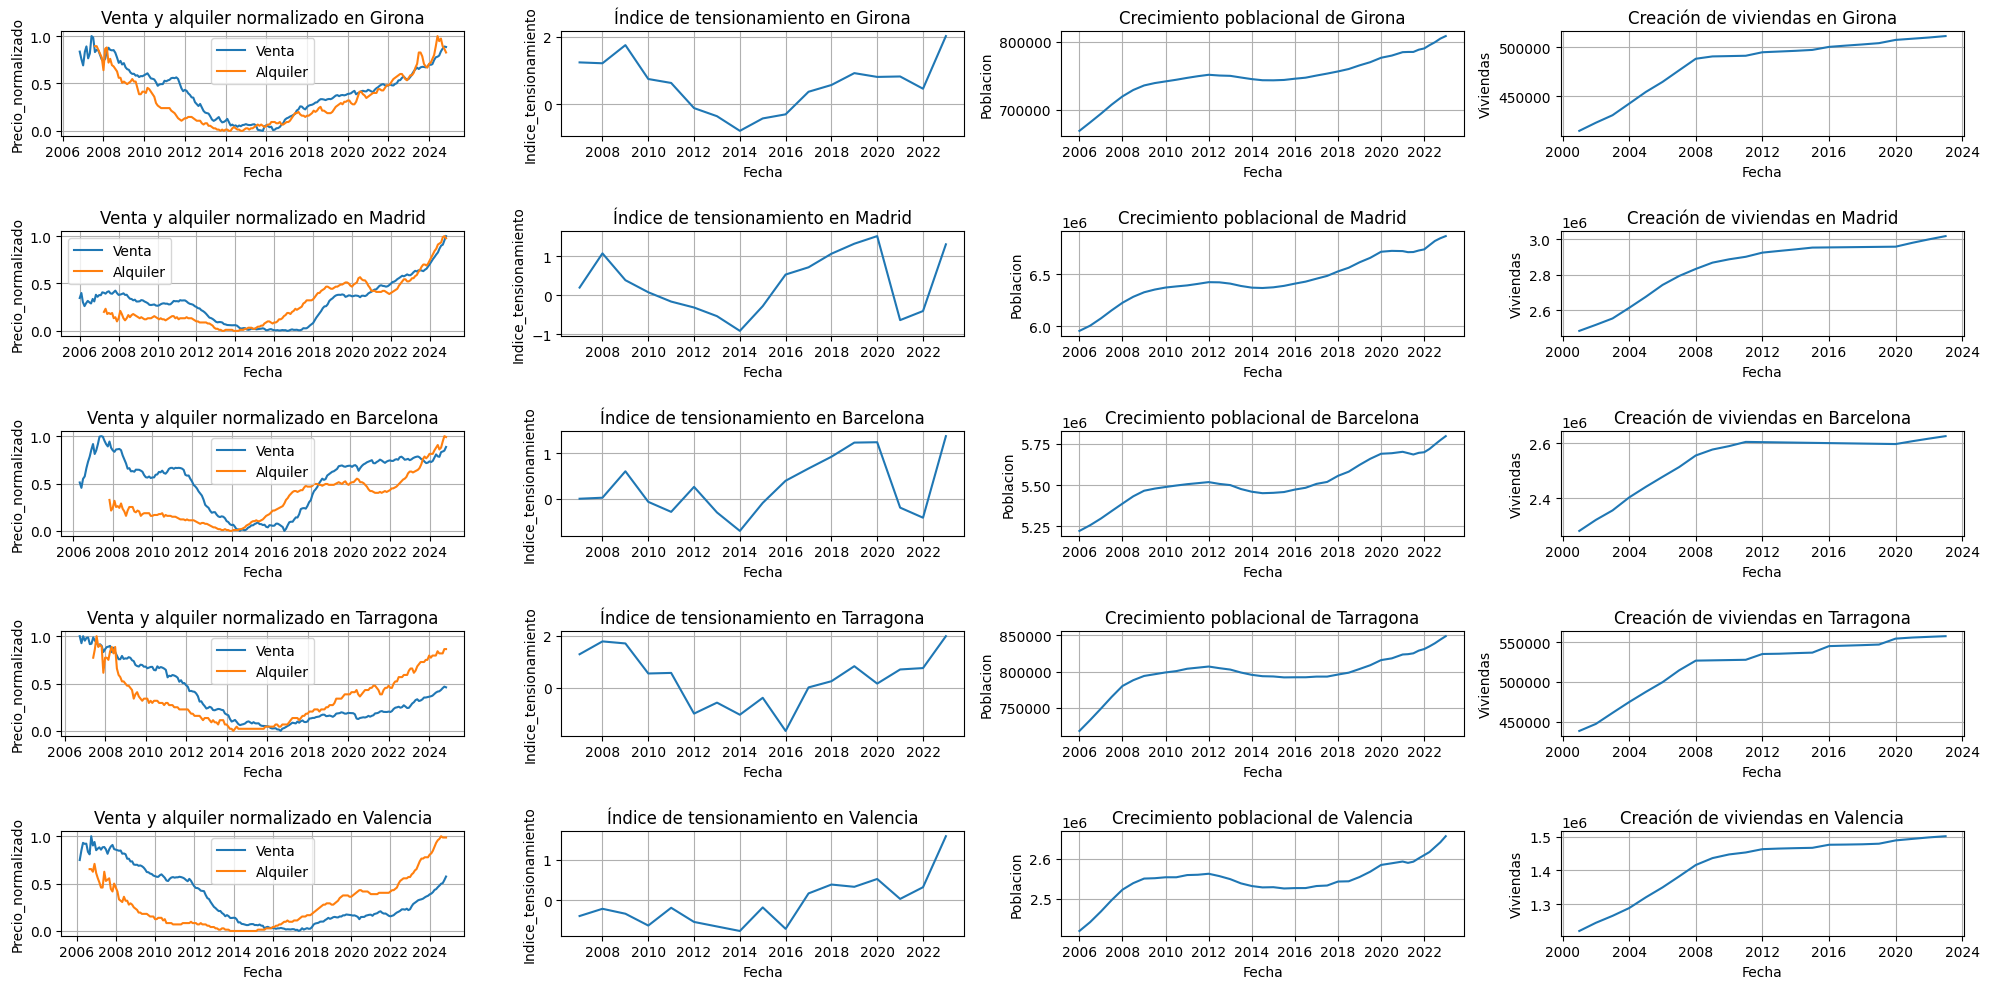

In [46]:
fig, ax = plt.subplots(5,4, figsize = (20,10))

for index, provincia in enumerate(lista_provincias_mas_tensionadas):

    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,0])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_tensionamiento[df_tensionamiento["Provincia"] == provincia], x = "Fecha", y = "Indice_tensionamiento", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Índice de tensionamiento en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_poblacion[df_poblacion["Provincia"] == provincia], x = "Fecha", y = "Poblacion", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Crecimiento poblacional de " + provincia)
    ax[index,2].grid(True)
    sns.lineplot(data = df_viviendas[df_viviendas["Provincia"] == provincia], x = "Fecha", y = "Viviendas", errorbar= None, ax = ax[index,3])
    ax[index,3].set_title("Creación de viviendas en " + provincia)
    ax[index,3].grid(True)

plt.tight_layout()
plt.plot()

[]

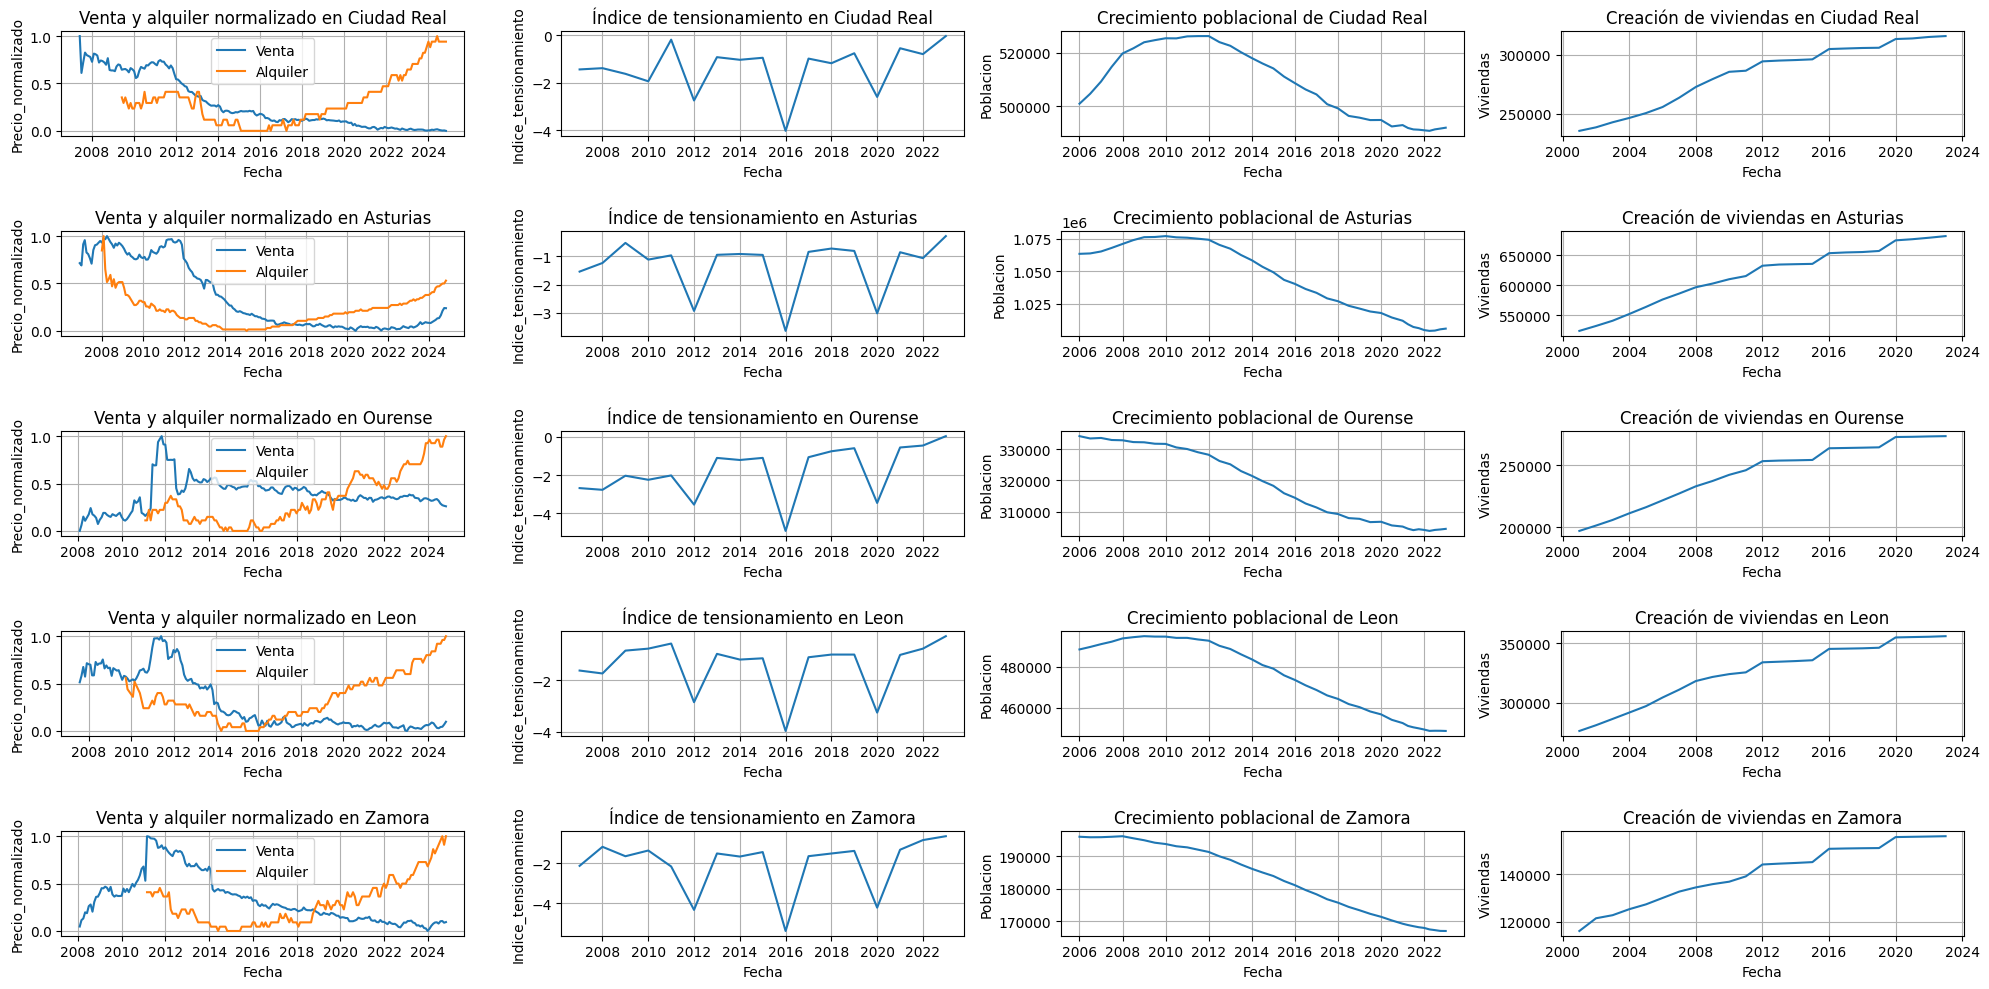

In [47]:
fig, ax = plt.subplots(5,4, figsize = (20,10))

for index, provincia in enumerate(lista_provincias_menos_tensionadas):

    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,0])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_tensionamiento[df_tensionamiento["Provincia"] == provincia], x = "Fecha", y = "Indice_tensionamiento", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Índice de tensionamiento en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_poblacion[df_poblacion["Provincia"] == provincia], x = "Fecha", y = "Poblacion", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Crecimiento poblacional de " + provincia)
    ax[index,2].grid(True)
    sns.lineplot(data = df_viviendas[df_viviendas["Provincia"] == provincia], x = "Fecha", y = "Viviendas", errorbar= None, ax = ax[index,3])
    ax[index,3].set_title("Creación de viviendas en " + provincia)
    ax[index,3].grid(True)

plt.tight_layout()
plt.plot()

### 3.6.1 Observaciones  

De este análisis se puede observar:  

- El alquiler sube en todas las provincias, aunque lo hace de forma más rápida en las que hay mayor tensionamiento
- Hay una clara relación entre el Índice de tensionamiento y el crecimiento del precio de venta. En el grupo de provincias con mayor tensionamiento, los picos, valles y respiros (momentos en los que no baja pero deja de subir) del precio de venta coinciden con los momentos de subida y bajada del Índice de tensionamiento.

### 3.7. Análisis final conjunto

Para este último análisis, se van a combinar todas los datasets en uno y después se va a calcular el cambio porcentual de cada dato desde 2016 hasta la última fecha disponible para el dataset más limitante.  Para ello:  

- Se van a encadenar múltiples "Inner Joins" para todos los datos. De esta manera sólo quedará la combinación de los valores de Provincia y Fecha que existan en todos los conjuntos.  
- Sobre el anterior, se va a calcular la diferencia porcentual entre el dato de Enero 2016 con respecto al último disponible.
- Debido a la estacionalidad del turismo, este dato no se va a incluir en la representación final, pues no es representativo de una evolución real.  
- Se va a añadir el Índice de tensionamiento calculado en el apartado anterior.
- Se a representar un HeatMap para poder comparar todos los incrementos en un mismo gráfico.

In [50]:
columnas_a_conservar = ["Fecha","Provincia","Precio_€/m2_venta","Precio_€/m2_alquiler","Poblacion","Viviendas","Salario","Viajeros"]

In [ ]:
df_combinado = pd.merge(left=df_venta, right=df_alquiler, on=["Fecha","Provincia"], how="inner")
df_combinado.rename(columns={"Precio_€/m2_x" : "Precio_€/m2_venta", "Precio_€/m2_y": "Precio_€/m2_alquiler"}, inplace=True)
df_combinado = pd.merge(left=df_combinado, right=df_salarios, on=["Fecha","Provincia"], how="inner").drop(["Comunidad_x","Comunidad_y"], axis = 1)
df_combinado = pd.merge(left=df_combinado, right=df_poblacion, on=["Fecha","Provincia"], how="inner").drop(["Comunidad_x","Comunidad_y"], axis = 1)
df_combinado = pd.merge(left=df_combinado, right=df_viviendas, on=["Fecha","Provincia"], how="inner")
df_combinado = pd.merge(left=df_combinado, right=df_turismo, on=["Fecha","Provincia"], how="inner")
df_combinado = df_combinado[["Fecha","Provincia","Precio_€/m2_venta","Precio_€/m2_alquiler","Poblacion","Viviendas","Salario","Viajeros"]]

df_combinado = df_combinado.sort_values(by=['Provincia', 'Fecha'])

df_combinado = df_combinado[columnas_a_conservar].reset_index(drop=True)
df_combinado.head()

Fecha Provincia  Precio_€/m2_venta  Precio_€/m2_alquiler  Poblacion  \
0   2009-01-01  A Coruna             1592.0                   7.0  1135287.0   
1   2010-01-01  A Coruna             1527.0                   6.1  1138107.0   
2   2011-01-01  A Coruna             1650.0                   5.7  1140069.0   
3   2012-01-01  A Coruna             1794.0                   5.9  1141178.0   
4   2013-01-01  A Coruna             1570.0                   5.4  1137890.0   
..         ...       ...                ...                   ...        ...   
586 2018-01-01  Zaragoza             1264.0                   7.0   958391.0   
587 2019-01-01  Zaragoza             1311.0                   7.3   965673.0   
588 2020-01-01  Zaragoza             1348.0                   7.8   973740.0   
589 2021-01-01  Zaragoza             1334.0                   8.0   973684.0   
590 2022-01-01  Zaragoza             1353.0                   8.1   968884.0   

     Viviendas  Salario  Viajeros  
0       637487   16.569     460.0  
1       644022   17.216     352.0  
2       647370   16.874     559.0  
3       658739   16.632     475.0  
4       660418   17.187     924.0  
..         ...      ...       ...  
586     535857   20.860    1982.0  
587     537014   20.605    1956.0  
588     543799   21.208    2610.0  
589     545762   22.220     695.0  
590     547525   22.734    1714.0  

[591 rows x 8 columns]

In [52]:
df_combinado = df_combinado.sort_values(by=['Provincia', 'Fecha'])

fecha_inicial = "2016-01-01"
fecha_final = df_combinado["Fecha"].max()

diccionario = {"Provincia": [],
               "Precio venta (%)" : [],
               "Precio alquiler (%)" : [],
               "Poblacion (%)" : [],
               "Viviendas (%)" : [],
               "Salario (%)" : [],
               #"Viajeros (%)" : []
               }

for provincia in df_combinado["Provincia"].unique():
    diccionario["Provincia"].append(provincia)

    valor_final = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_final)]["Precio_€/m2_venta"].values[0]
    valor_inicial = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_inicial)]["Precio_€/m2_venta"].values[0]
    cambio_valor = float(((valor_final-valor_inicial)/valor_inicial) * 100)
    
    diccionario["Precio venta (%)"].append(cambio_valor)

    valor_final = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_final)]["Precio_€/m2_alquiler"].values[0]
    valor_inicial = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_inicial)]["Precio_€/m2_alquiler"].values[0]
    cambio_valor = float(((valor_final-valor_inicial)/valor_inicial) * 100)
    
    diccionario["Precio alquiler (%)"].append(cambio_valor)

    valor_final = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_final)]["Poblacion"].values[0]
    valor_inicial = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_inicial)]["Poblacion"].values[0]
    cambio_valor = float(((valor_final-valor_inicial)/valor_inicial) * 100)
    
    diccionario["Poblacion (%)"].append(cambio_valor)

    valor_final = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_final)]["Viviendas"].values[0]
    valor_inicial = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_inicial)]["Viviendas"].values[0]
    cambio_valor = float(((valor_final-valor_inicial)/valor_inicial) * 100)
    
    diccionario["Viviendas (%)"].append(cambio_valor)

    valor_final = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_final)]["Salario"].values[0]
    valor_inicial = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_inicial)]["Salario"].values[0]
    cambio_valor = float(((valor_final-valor_inicial)/valor_inicial) * 100)
    
    diccionario["Salario (%)"].append(cambio_valor)
"""
    valor_final = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_final)]["Viajeros"].values[0]
    valor_inicial = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_inicial)]["Viajeros"].values[0]
    cambio_valor = float(((valor_final-valor_inicial)/valor_inicial) * 100)

    diccionario["Viajeros (%)"].append(cambio_valor)
"""   
    

'\n    valor_final = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_final)]["Viajeros"].values[0]\n    valor_inicial = df_combinado[(df_combinado["Provincia"] == provincia) & (df_combinado["Fecha"] == fecha_inicial)]["Viajeros"].values[0]\n    cambio_valor = float(((valor_final-valor_inicial)/valor_inicial) * 100)\n\n    diccionario["Viajeros (%)"].append(cambio_valor)\n'

In [53]:
df_porcentajes_cambio = pd.DataFrame(diccionario)
df_porcentajes_cambio["Indice tensionamiento"] = df_tensionamiento[df_tensionamiento["Fecha"] == df_tensionamiento["Fecha"].max()].sort_values("Provincia").reset_index(drop=True)["Indice_tensionamiento"]
df_porcentajes_cambio.set_index("Provincia", inplace=True)
df_porcentajes_cambio = df_porcentajes_cambio[["Precio venta (%)","Precio alquiler (%)","Indice tensionamiento","Salario (%)","Poblacion (%)"]]
df_porcentajes_cambio.head()

Precio venta (%)  Precio alquiler (%)  Indice tensionamiento  \
Provincia                                                                 
A Coruna         -10.868031            37.254902               0.227631   
Alava             19.055464            27.631579               0.339269   
Albacete          -1.432665            37.777778               0.066093   
Alicante          28.278999            38.888889               2.252230   
Almeria            1.303538            32.653061               1.645113   

           Salario (%)  Poblacion (%)  
Provincia                              
A Coruna     12.961534      -0.342916  
Alava        15.710333       3.385412  
Albacete     14.562238      -1.505110  
Alicante     15.332075       3.788129  
Almeria      10.148460       5.640414

In [54]:
df_porcentajes_cambio = df_porcentajes_cambio.sort_values(by="Precio venta (%)", ascending=False)

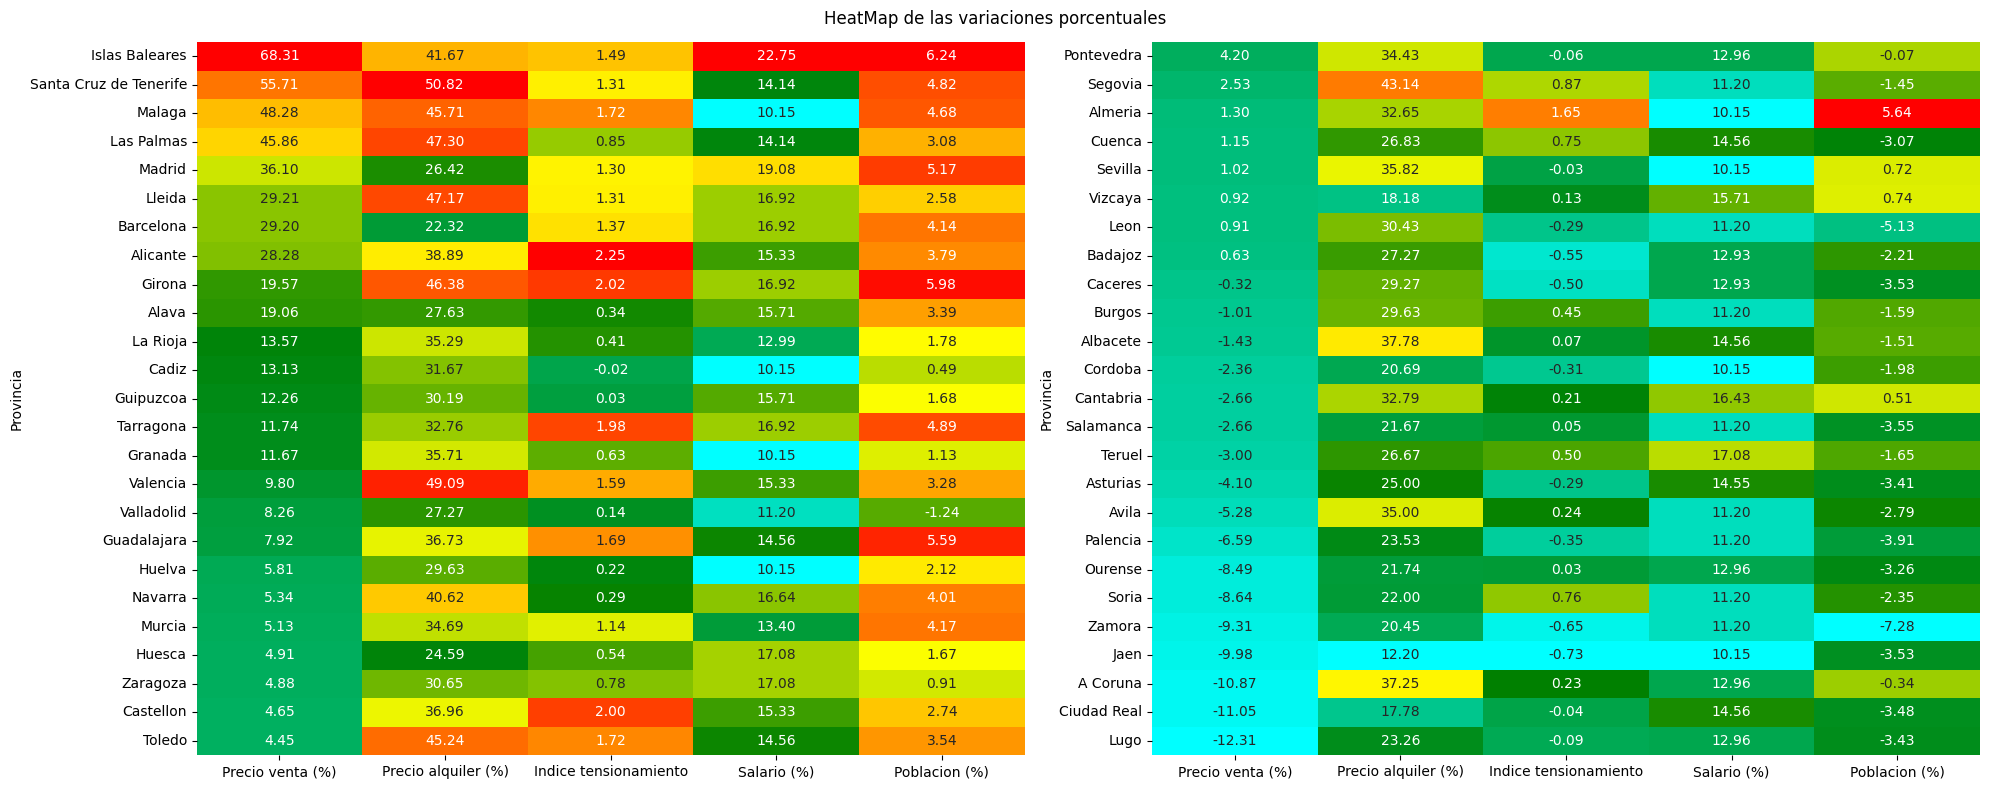

In [55]:
normalized_df = df_porcentajes_cambio.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Crear el heatmap con la matriz normalizada
from matplotlib.colors import LinearSegmentedColormap
blue_to_red = LinearSegmentedColormap.from_list("BlueToRed", ["cyan","green", "yellow", "red"])

fig, axs = plt.subplots(1,2,figsize=(20, 8))
sns.heatmap(normalized_df.iloc[0:25,:], annot=df_porcentajes_cambio.iloc[0:25,:], fmt='.2f', cmap=blue_to_red, cbar=False, ax = axs[0])
sns.heatmap(normalized_df.iloc[25:,:], annot=df_porcentajes_cambio.iloc[25:,:], fmt='.2f', cmap=blue_to_red,cbar=False,ax = axs[1])
fig.suptitle("HeatMap de las variaciones porcentuales")
plt.tight_layout()
plt.show()


### 4. Conclusiones.  

Tras todo lo anterior, se puede llegar a las siguientes conclusiones:  

- El precio de venta de las viviendas sigue un comportamiento desigual entre las diferentes provincias. Se ve afectado por:  
    - Turismo: No es determinante de forma directa sobre el precio de venta. Se vió que, en algunas provincias en las que el número de turistas no ha crecido, también se han experimentado incrementos en los precios de venta. Este parámetro tiene un mayor efecto en el incremento de precios de alquiler, por lo que puede afectar de forma indirecta. Causaría que tener una vivienda en propiedad para alquilar sea más interesante en estas zonas.
    - Población: Si la población de una provincia sube, el precio de la vivienda de esa región también aumenta con algunas excepciones, como es el caso de Almeria. Sin embargo, se vio que el crecimiento de la población no afecta por si mismo al precio de venta, si no que lo hace en función de como sea del ritmo de crecimiento del número de viviendas.
    - Salarios: Los salarios han crecido de manera uniforme y en todas las provincias. El precio de venta se ha incrementado en unas y ha bajado en otras, por lo que no se puede concluir que los salarios afecten al precio de venta.
    - Índice de tensionamiento: Este índice está muy relacionado con el incremento de los precios de venta. Salvo excepciones, las provincias que han experimentado mayores incrementos en el precio de venta presentan índices de tensionamiento positivos. Como se observa en el HeatMap derecho del bloque anterior, el índice de tensionamiento es bajo (incluso negativo) en las provincias en las que el precio de venta no aumenta o disminuye. Además, como se vió gráficamente en el apartado 3.6, los picos y valles de este índice a lo largo del tiempo coinciden con picos, valles y llanuras de los gráficos de la evolución de precios.

- El precio del alquiler, aunque de forma desigual, se ha visto incrementado en todas las provincias. Se ve afectado por:
    - Turismo: A pesar de subir en todas las provincias, el precio del alquiler presenta un crecimiento superior en aquellas en las que hay un mayor número de turistas. Esto se pudo comprobar de forma numérica en el apartado 3.3
    - Población: El crecimiento o disminución de la población residente, por si solo, no tiene un efecto significativo en el precio del alquiler, pues crece incluso en aquellas provincias en las que el número de habitantes decrece. Su efecto es función de como sea del ritmo de crecimiento el número de viviendas.
    - Salarios: De igual forma que ocurre con el precio de vivienda, los salarios crecen en todas las provincias. El alquiler también, pero no lo hace de forma proporcional, por lo que, a pesar de que es cierto que pueda tener alguna influencia, se descartó que los salarios sean el principal causante de las subidas en el precio del alquiler.
    - Índice de tensionamiento: Se observó que un índice de tensionamiento elevado causa que el precio del alquiler se incremente en mayor medida que las provincias en las que este índice es bajo.

- Correlación precio de venta y alquiler: La correlación entre ambas no es un fenómeno general. Las provincias en las que el alquiler aumenta significativamente, tienen también los mayores incrementos en los precios de la vivienda presentando unos elevados valores de correlación positiva. Sin embargo, los alquileres también crecen en aquellas provincias en las que el precio de venta disminuye, presentandose en este caso una correlación negativa. No se puede concluir, por lo tanto, que a nivel general exista correlación entre ambos. Son, por lo tanto, otros factores los que afectan a su evolución a lo largo del tiempo.

In [56]:
# Codigo opcional para representar provincias mas significativas:

""" lista_total = []
lista_total.extend(list(lista_provincias_mayor_correlacion_precios))
lista_total.extend(list(lista_provincias_menor_correlacion_precios))
lista_total.extend(list(lista_provincias_mayor_crecimiento_venta))
lista_total.extend(list(lista_provincias_mayor_crecimiento_alquiler))
lista_total.extend(list(lista_provincias_menor_crecimiento_venta))
lista_total.extend(list(lista_provincias_menor_crecimiento_alquiler))
lista_total.extend(list(lista_provincias_mas_turistas))
lista_total.extend(list(lista_provincias_menos_turistas))
lista_total.extend(list(lista_provincias_mayor_aumento_poblacion))
lista_total.extend(list(lista_provincias_disminucion_poblacion))
lista_total.extend(list(lista_provincias_mayor_crecimiento_salarial))
lista_total.extend(list(lista_provincias_menor_crecimiento_salarial))
lista_total.extend(list(lista_provincias_mas_tensionadas))
lista_total.extend(list(lista_provincias_menos_tensionadas))
lista_total = sorted(list(set(lista_total)))
print(lista_total)
print(len(lista_total))
"""

"""
fig, ax = plt.subplots(len(lista_total),5, figsize = (20,80))

for index, provincia in enumerate(lista_total):
    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,0])
    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,0])
    ax[index,0].set_title("Venta y alquiler normalizado en " + provincia)
    ax[index,0].grid(True)
    sns.lineplot(data = df_turismo[df_turismo["Provincia"] == provincia], x = "Fecha", y = "Viajeros", errorbar= None, ax = ax[index,1])
    ax[index,1].set_title("Número de turistas en " + provincia)
    ax[index,1].grid(True)
    sns.lineplot(data = df_poblacion[df_poblacion["Provincia"] == provincia], x = "Fecha", y = "Poblacion", errorbar= None, ax = ax[index,2])
    ax[index,2].set_title("Número de habitantes en " + provincia)
    ax[index,2].grid(True)
    sns.lineplot(data = df_salarios[df_salarios["Provincia"] == provincia], x = "Fecha", y = "Salario", errorbar= None, ax = ax[index,3])
    ax[index,3].set_title("Evolución salarial en " + provincia)
    ax[index,3].grid(True)
    sns.lineplot(data = df_tensionamiento[df_tensionamiento["Provincia"] == provincia], x = "Fecha", y = "Indice_tensionamiento", errorbar= None, ax = ax[index,4])
    ax[index,4].set_title("Indice de tensionamiento en " + provincia)
    ax[index,4].grid(True)
plt.tight_layout()
plt.plot() 
"""

'\nfig, ax = plt.subplots(len(lista_total),5, figsize = (20,80))\n\nfor index, provincia in enumerate(lista_total):\n    sns.lineplot(data = df_venta[df_venta["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Venta", errorbar= None, ax = ax[index,0])\n    sns.lineplot(data = df_alquiler[df_alquiler["Provincia"] == provincia], x = "Fecha", y = "Precio_normalizado",  label = "Alquiler", errorbar= None, ax = ax[index,0])\n    ax[index,0].set_title("Venta y alquiler normalizado en " + provincia)\n    ax[index,0].grid(True)\n    sns.lineplot(data = df_turismo[df_turismo["Provincia"] == provincia], x = "Fecha", y = "Viajeros", errorbar= None, ax = ax[index,1])\n    ax[index,1].set_title("Número de turistas en " + provincia)\n    ax[index,1].grid(True)\n    sns.lineplot(data = df_poblacion[df_poblacion["Provincia"] == provincia], x = "Fecha", y = "Poblacion", errorbar= None, ax = ax[index,2])\n    ax[index,2].set_title("Número de habitantes en " + provincia)\n    ax